<h1 style='color:orange; text-align:center; font-weight:bold'>Predicting Gender Category from Indonesian Personal Names Using 3-Character N-Grams</h1>
<h5 style='text-align:center; font-style:italic'>LingAdeu</span>

## **1 Introduction**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

The dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/dionisiusdh/indonesian-names).

In [330]:
# DATA EXPLORATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
from sklearn.utils import resample
pd.options.display.max_colwidth = 50
plt.style.use('ggplot')
import string

# MACHINE LEARNING
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from  sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.metrics import precision_score, roc_auc_score
import time                                                         
from sklearn.metrics import classification_report                   
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score  
from sklearn.calibration import CalibratedClassifierCV
from lime.lime_text import LimeTextExplainer
import eli5
import dice_ml
from eli5.sklearn import PermutationImportance
import joblib

## **2 Data Preparation and Exploration**
In this section, I aim to understand the dataset before developing a predictive model. The data understanding process will be done by examining data types, number of features, duplicates, class distribution, and missing values. This process will also be supplemented by a statistical data analysis based on features extracted from column `name`. While this inferential statistics does not provide a further understanding on data for the predictive modeling, this analysis will inform whether or not the magnitude of differences in male and female names is statistically significant.

### **2.1 Data Preparation**

In [331]:
# load the dataset
df = pd.read_csv('../data/indonesian-names.csv')

print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
df.sample(n=10, random_state=42)

The dataframe contains 1960 rows and 2 cols.
- 0 are numeric cols
- 2 are object cols


,name,gender
1096,ahmad hasinul fikqih,m
572,siti nur azijah,f
450,sumini,f
383,sumono,m
1489,ruhdi,m
1402,kadirin,m
128,indri dian pertiwi,m
1475,suyanto,m
824,arif nova baihaqi,m
239,muhammad ilham,m


**Note**
- The dataset only consists of two categorical columns, namely `name` and `gender`. Column `name` will be split up using character n-grams to examine the patterns in sequences of characters in the names.
- In addition to extracting character n-grams, I will also extract numerical information from column `name`. This feature extraction is expected to provide a numerical understanding of male and female differences in names.
- Before continuing the feature extraction, I need to check the basic sanity of the dataset such as missing values, duplicates, and proportions of female and male names.


In [332]:
# check missing values
df.isna().mean()*100

name      0.0
gender    0.0
dtype: float64

**Note**: The dataset does not contain any missing values. No missing value detections and treatment will be necessary. For this reason, I can move on checking whether there are any duplicates in the dataset. Duplicate checking is crucial to get good quality of input data for a machine learning model and a statistical analysis. For predictive modeling, for example, duplicates will be trouble some when they are present in both training and testing sets since the model is tested using the same instance for which it is trained. In a statistical analysis, duplicates will distort variability in the distribution. If appearing multiple times, the variance as the measure of data spread can be low, indicating lower variability. While lower variance is generally preferable, it is not expected when the samples are duplicated. For this reason, insights obtained from dataset containing duplicates is misleading. 

In [333]:
# check duplicates
duplicates = df.duplicated().sum()
duplicate_rate = round(df.duplicated().sum()/len(df)*100, 2)
print(f'Total duplicates: {duplicates} ({duplicate_rate} of sample size)')
df[df.duplicated(keep=False)].sort_values(by='name').head(10)

Total duplicates: 164 (8.37 of sample size)


,name,gender
1020,ahmad hasinul fikqih,m
1096,ahmad hasinul fikqih,m
1140,ahmad priyanto,m
1064,ahmad priyanto,m
1120,ahmad tona,m
1044,ahmad tona,m
1101,aila annafi'an zaini,f
1025,aila annafi'an zaini,f
1138,andi sofyan,m
1062,andi sofyan,m


**Note**
- The output shows the presence of duplicates in the dataset (8.37%). In general, based on the dataframe, several names such as "Ahmad Hasinul Fikqih", "Ahmad Priyanto", and "Ahmad Tona" appear twice. Due to the potential negative effects of duplicates on the insights, they must be removed from the dataset. 
- The removal is done by retaining the first entry only. The second and the following duplicates (if any) will be automatically be removed.

In [334]:
# drop duplicates
df.drop_duplicates(keep='first', inplace=True)

In [335]:
# double check duplicates
df.duplicated().sum()

0

**Note**: The duplicates have been removed from the dataset. The data check can be proceeded by calculating the class distribution of gender status. This step  is crucial to understand to what extent the distribution between male and female names is imbalanced. When the distribution is highly uneven, the imbalance class will pose a problem in the machine learning model such as biased predictions to the majority class and lower sensitivity to the minority class. Biased predictions mean that the model more frequently predicts the majority class. And lower sensitivity means that the model is less capable of detecting instances in the minority class. If the class disribution is uneven, resampling, e.g., undersampling (NearMiss) or oversampling (SMOTE or ADASYN), can be used to balance the distribution.

In [336]:
# calculate class distribution in gender
gender_df = pd.DataFrame({'gender': (df['gender'].value_counts(normalize=True)*100).index,
              'rate':(df['gender'].value_counts(normalize=True)*100).values}).round(2)
gender_df

,gender,rate
0,m,55.79
1,f,44.21


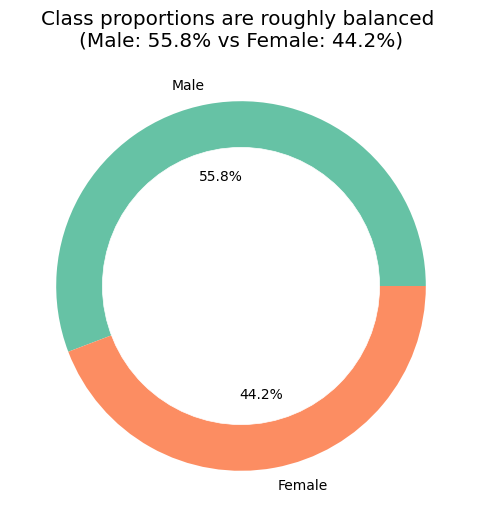

In [337]:
fig, ax = plt.subplots(figsize=(10, 6))
circle_center = plt.Circle( (0, 0), 0.75, color='white')
plt.pie(gender_df['rate'], labels=['Male', 'Female'], 
        autopct='%1.1f%%', startangle=0, 
        colors=['#66c2a5', '#fc8d62'])
p = plt.gcf()
p.gca().add_artist(circle_center)
plt.title('Class proportions are roughly balanced \n(Male: 55.8% vs Female: 44.2%)')
plt.show()
plt.show()

**Note**
- A severe imbalance is usually considered when one class is over 70% of the total sample. However, the distribution of male and female class in the target variable is roughly balanced (55.8 vs 44.2). Consequently, no treatments need to be given to balance the classes.
- For the next step, I will check the cleanliness of the column `name` before extracing features from it. The cleanliness check is performed by investigating whether names contain punctuation marks. This process is crucial because in addition to periods, Indonesian names usually contain apostrophes, especialy names with an Arabic origin (parsial or full) such as *Do'a* and *Nu'in* below. The apostrope in Indonesian usually represents the glottal stop or glottal plosive sound.
- The punctuation symbols must be removed before extracting character n-grams because the symbols will affect the n-grams, leading to potentially noise in the dataset fed to the model. 

In [338]:
# check punctuation marks
df[df['name'].str.contains(r'[^\w\s]', regex=True)].head()

,name,gender
20,habil sabilla do'a,f
96,m. muawam,m
97,m. yassir saputra jamina,m
287,nu' in sofyan,m
298,m. charly iman nugroho,m


**Note**: The punctuation marks here will be removed using the following code. And the names will be rechecked using the same regex patterns to detect any remainders in the punctuation removal.

In [339]:
# remove punctuation marks
explore_df = df.copy()
explore_df['name'] = explore_df['name'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

# check if still any punctuation marks
explore_df[explore_df['name'].str.contains(r'[^\w\s]', regex=True)].head()

,name,gender


**Note**
- The dataset does not contain any punctuation marks anymore. Now, feature extraction from `name` can be carried out. 
- For analysis purposes, I will add word count, chatacter count, number of vowels and consonants. The measures will provide more understanding of names across gender status from the structural perspective, and therefore, adding importance of a linguistic analysis.
- When analyzing structural properties of names, it is actually possible to investigate consonant clusters in the names but this analysis will not include this linguistic topic. Consonant clusters will be greatly useful when the analysis focuses more on generational differences to see cultural shift. For instance, pre-generation X names, especially from Javanese ethnic, usually use one-word name with small variations in open or closed syllabic constructions (e.g., *mar-gɔ-nɔ* (M) vs *pɔn-i-rah* (F)). And names in gen Z onward at glance tend to be more inclusive of non-native Javanese phonemes, e.g., palato-alveolar sibilant ʃ or alveolar fricative z (as in *mei-ʃa az-zah-ra* (F)), in Javanese society. 

In [340]:
# extract word count and character count from name
explore_df['wordcount'] = explore_df['name'].str.split().str.len()
explore_df['charcount'] = explore_df['name'].apply(lambda x: len(x))
explore_df.head()

,name,gender,wordcount,charcount
0,hafizhan shidqi,m,2,15
1,gandhi wibowo,m,2,13
2,aldio mahendra purwandrarto,m,3,27
3,benny putra,m,2,11
4,vicky vernando dasta,m,3,20


In [341]:
# function to count vowels and consonants
def count_vowels_consonants(name):
    vowels = 'aeiou'
    consonants = 'bcdfghjklmnpqrstvwxyz'
    num_vowels = sum(name.count(vowel) for vowel in vowels)
    num_consonants = sum(name.count(consonant) for consonant in consonants)
    
    return num_vowels, num_consonants

# apply function
explore_df['vowelcount'], explore_df['conscount'] = zip(*explore_df['name'].apply(count_vowels_consonants))

# display the DataFrame
explore_df.head()


,name,gender,wordcount,charcount,vowelcount,conscount
0,hafizhan shidqi,m,2,15,5,9
1,gandhi wibowo,m,2,13,5,7
2,aldio mahendra purwandrarto,m,3,27,10,15
3,benny putra,m,2,11,3,7
4,vicky vernando dasta,m,3,20,6,12


### **2.2 Data Analysis**
#### **2.2.1 Do numerical features follow normal distributions?**
As this section will perform a quantitative analysisis on name length, some tests on parametric assumptions, particularly normality of distribution and equal variances between groups in question, must be done to draw valid conclusions from the tests. If the series of tests indicate normal distribution and equal variances (homoescedasticity), statistical test which can be used here is an independent *t*-test for group difference. Otherwise, the non-parametric test counterpart, Mann-Whitney *U*, can be an alternative when one or two assumptions are violated.

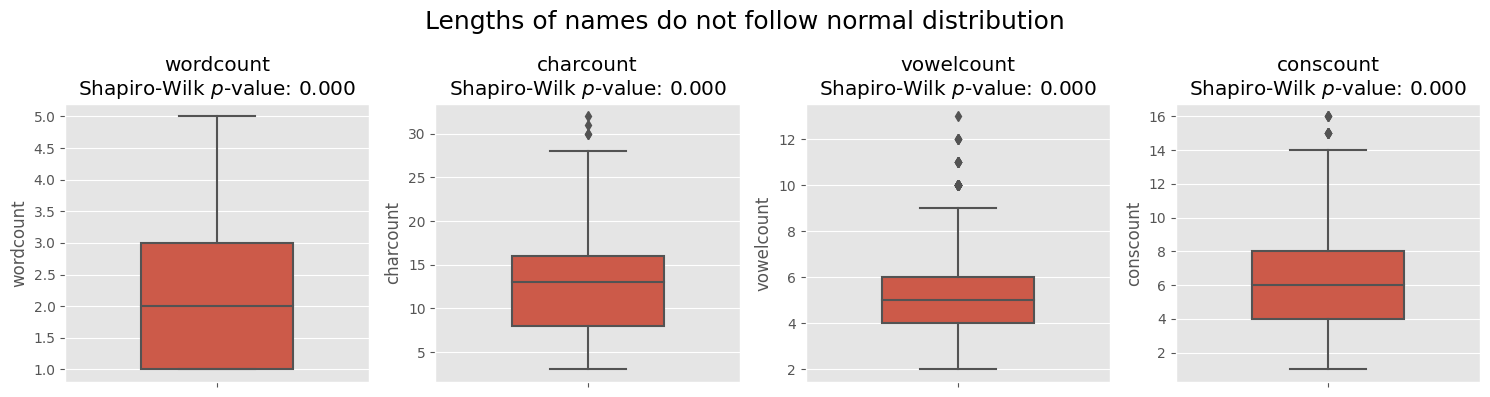

In [342]:
numerical_columns = explore_df.select_dtypes(include='number')

plt.figure(figsize=(15, 4))

# create boxplot
for i, col in enumerate(numerical_columns):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=explore_df[col], width=0.5)
    stat, p_value = shapiro(explore_df[col].dropna())
    plt.title(f'{col}\nShapiro-Wilk $p$-value: {p_value:.3f}')

plt.suptitle('Lengths of names do not follow normal distribution', size=18)
plt.tight_layout()
plt.show()

**Note**: Using Shapiro-Whilk *W* test with null hypothesis of normal distribution, the all numerical features do not follow the normal distribution (*p* < 0.05). For this reason, the assumption of normality is not met. Based on this violation of assumption only, a non-parametric test, particularly Mann-Whitney *U* test for comparing male and female names can be a primary option. But before moving forward, I will check the homoscedasticity assumption first.

In [343]:
# create function to compute kurtosis & skewness
def compute_kurtosis_and_skew(group):
    return pd.Series({
        'wordcount__kurtosis': kurtosis(group['wordcount'].dropna()),
        'wordcount__skew': skew(group['wordcount'].dropna()),
        'charcount__kurtosis': kurtosis(group['charcount'].dropna()),
        'charcount__skew': skew(group['charcount'].dropna()),
        'vowelcount__kurtosis': kurtosis(group['vowelcount'].dropna()),
        'vowelcount__skew': skew(group['vowelcount'].dropna()),
        'conscount__kurtosis': kurtosis(group['conscount'].dropna()),
        'conscount__skew': skew(group['conscount'].dropna())
    })

explore_df.groupby('gender').apply(compute_kurtosis_and_skew).transpose()

gender,f,m
wordcount__kurtosis,-0.644453,-0.316320
wordcount__skew,0.350893,0.482408
charcount__kurtosis,-0.673870,-0.068909
charcount__skew,0.336435,0.519525
vowelcount__kurtosis,-0.379800,0.169131
vowelcount__skew,0.459100,0.588126
conscount__kurtosis,-0.412962,-0.006677
conscount__skew,0.478616,0.586595


#### **2.2.2 Are the variances between male and female equal?**
To test the assumption of equal variances, I use Levene's test. This statistical test checks whether the variances between two or more groups are substantially different. If they are substantially different, the homogeneity assumption is violated.

In [344]:
numerical_columns = explore_df.select_dtypes(include='number').columns
results = []

# perform Levene's test
for col in numerical_columns:
    group1 = explore_df[explore_df['gender'] == 'm'][col].dropna()
    group2 = explore_df[explore_df['gender'] == 'f'][col].dropna()
    levene_stat, p_value = levene(group1, group2)
    conclusion = 'Variances are significantly different' if p_value < 0.05 else 'Variances are not significantly different'
    results.append({'F-stat': levene_stat, 'p-value': p_value, 'Conclusion': conclusion})

# create df to display result
pd.DataFrame(results, index=numerical_columns)

,F-stat,p-value,Conclusion
wordcount,0.073187,0.786783,Variances are not significantly different
charcount,2.029079,0.154488,Variances are not significantly different
vowelcount,1.900265,0.168220,Variances are not significantly different
conscount,16.459019,0.000052,Variances are significantly different


**Note**
- A comparison between male and female name lengths based on different linguistic features suggest that only the number of consonants in names violates from the homogeneity of variances. Other three variables, namely `wordcount`, `charcount`, and `vowelcount`, have roughly equal variances.
- While some features indicate homogeneity of variances, these feature fail to meet the normality assumption which is strictly neeeded for a parametric test. For this reason, Mann-Whitney *U* test will be used to evaluate differences between gender statuses. This group difference test will also be complemented by rank-biserial effect size ($r$) along with the confidence interval of the effect size.
- While Mann-Whitney *U* test can tell whether there is sufficient evidence to check significant group difference, this test actually only tells a half of the story.
- Effect size, particularly rank-biserial effect size, quantfies the strength of difference between two groups. This adds practical importance of the statistical significance from the Mann-Whitney *U* test. In simple terms, unlike statistical significance which only tells if a difference exists between groups, effect size informs how big or small the difference between groups is.
- Additionally, confidence interval provides a range of values for the true effect size in the population.

#### **2.2.3 Is there any significant difference between male and female in terms of word counts?**

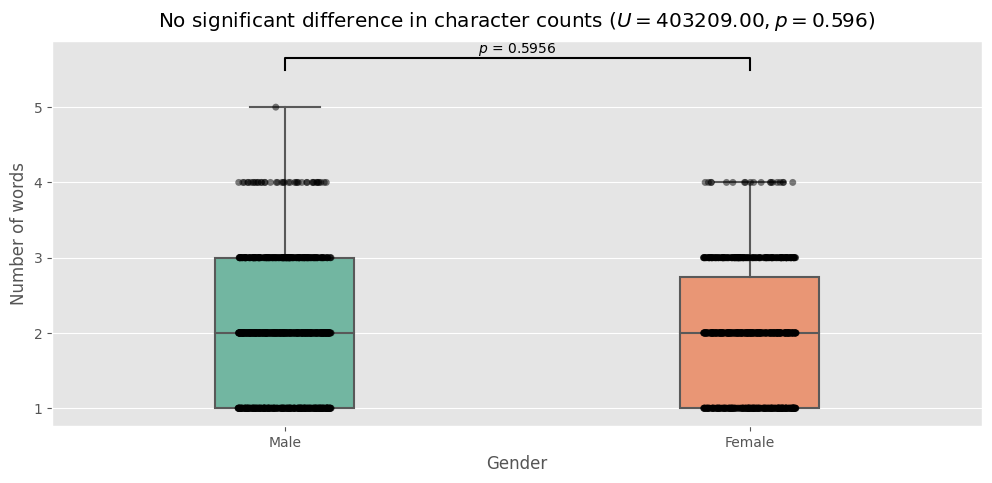

In [345]:
# prepare data
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['wordcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['wordcount']

# perform Mann-Whitney U test
stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# Visualize the difference
plt.figure(figsize=(12, 5))
sns.boxplot(x='gender', y='wordcount', data=explore_df, palette='Set2', width=0.3)
sns.stripplot(x='gender', y='wordcount', data=explore_df, color='k', alpha=0.5, jitter=True)

# calculate the vertical offset for annotations
max_y = max(explore_df['wordcount'])
offset = max_y * 0.1 

# determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # vertical position of the bracket
h = offset * 0.3    # height of the bracket
col = 'k'           # line color

# add a bracket-style line
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'No significant difference in character counts ($U={stat:.2f}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Gender')
plt.ylabel('Number of words')
current_labels = plt.gca().get_xticklabels()  
plt.gca().set_xticklabels(['Male', 'Female'])  
plt.show()

In [346]:
# create function to calculate effect size
def rank_biserial_effectsize(u_statistic, n1, n2):
    return (u_statistic - (n1 * n2 / 2)) / (n1 * n2)

# create function to compute CI
def bootstrap_ci(data1, data2, num_iterations=1000, alpha=0.05):
    boot_stats = []
    n1, n2 = len(data1), len(data2)
    
    for _ in range(num_iterations):
        sample1 = resample(data_group1)
        sample2 = resample(data_group2)
        u_statistic, _ = mannwhitneyu(sample1, sample2, alternative='two-sided')
        effect_size = rank_biserial_effectsize(u_statistic, n1, n2)
        boot_stats.append(effect_size)
    
    boot_stats = np.array(boot_stats)
    lower_bound = np.percentile(boot_stats, 100 * alpha / 2)
    upper_bound = np.percentile(boot_stats, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [347]:
# split data by gender
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['wordcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['wordcount']

# calculate Mann-Whitney U statistic
u_statistic, _ = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

pd.DataFrame({'U_stat': stat, 
              'p-value': p_value,
              'effect_size': effect_size,
              '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]}).round(3)

,U_stat,p-value,effect_size,95%CI
0,403209.0,0.596,0.007,"[-0.017, 0.032]"


**Note**
- Male and female names in terms of word counts are not statistically significant (*U* = 403209.0, *p* = 0.596). The rank-biserial effect size is very small (*r* = 0.007), suggesting a very small effect. 
- The 95% confidence interval for the effect size range between -0.017 and 0.03, which includes zero, further supporting the conclusion that there is no meaningful differtence between two gender groups.

#### **2.2.4 In terms of character counts, do male and female names have a significant difference?**

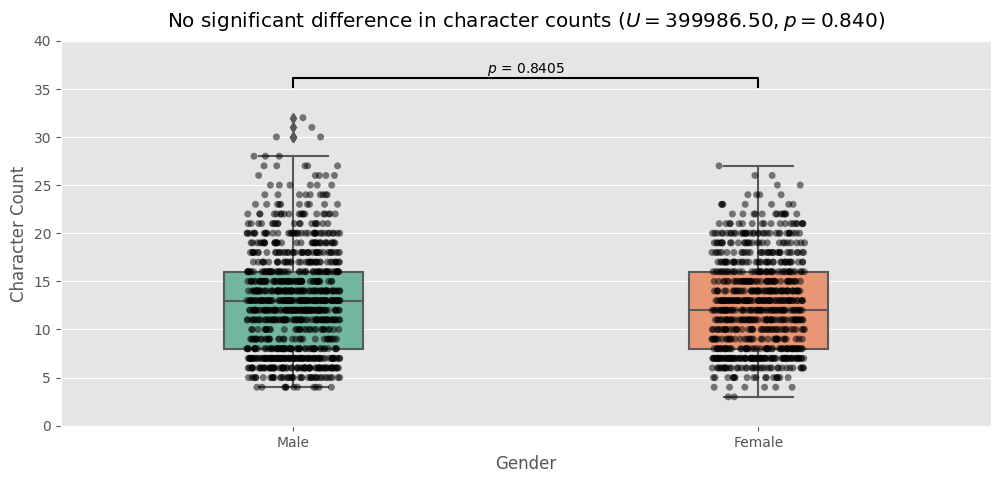

In [348]:
# Prepare data
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['charcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['charcount']

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# Visualize the difference
plt.figure(figsize=(12, 5))
sns.boxplot(x='gender', y='charcount', data=explore_df, palette='Set2', width=0.3)
sns.stripplot(x='gender', y='charcount', data=explore_df, color='k', alpha=0.5, jitter=True)

# Calculate the vertical offset for annotations
max_y = max(explore_df['charcount'])
offset = max_y * 0.1  # 10% of the y-axis range as an offset

# Determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # Vertical position of the bracket
h = offset * 0.3    # Height of the bracket
col = 'k'           # Color of the line and text

# Add a bracket-style line
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'No significant difference in character counts ($U={stat:.2f}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Gender')
plt.ylabel('Character Count')
current_labels = plt.gca().get_xticklabels()    # Get current y-tick labels
plt.gca().set_xticklabels(['Male', 'Female'])   # Replace with new labels
plt.ylim(0, 40)
plt.show()

In [349]:
# split data by gender
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['charcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['charcount']

# calculate Mann-Whitney U statistic
u_statistic, _ = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

pd.DataFrame({'U_stat': stat, 
              'p-value': p_value,
              'effect_size': effect_size,
              '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]}).round(3)

,U_stat,p-value,effect_size,95%CI
0,399986.5,0.84,0.003,"[-0.024, 0.03]"


**Note**
- Similar to previous variable, in general, the difference between male and female names in terms of character counts is minor.
- As can be seen, the probability value of the Mann-Whitney *U* test is greater than the alpha at 0.05 (*U* = 399986.5, *p* = 0.84), meaning no substantial difference between the two groups.
- The effect size (rank-biserial) is also tiny (*r* = 0.003). And to estimate the true effect size in the population, a bootstrapped 95% confidence interval was computed, resulting in an inclusion of zero range (-0.024, 0.03). 
- Altogether, these three tests indicate that two gender groups exhibit no meaningful difference in terms of character counts.

#### **2.2.5 Do males and females have significant differences in the number of vowels?**

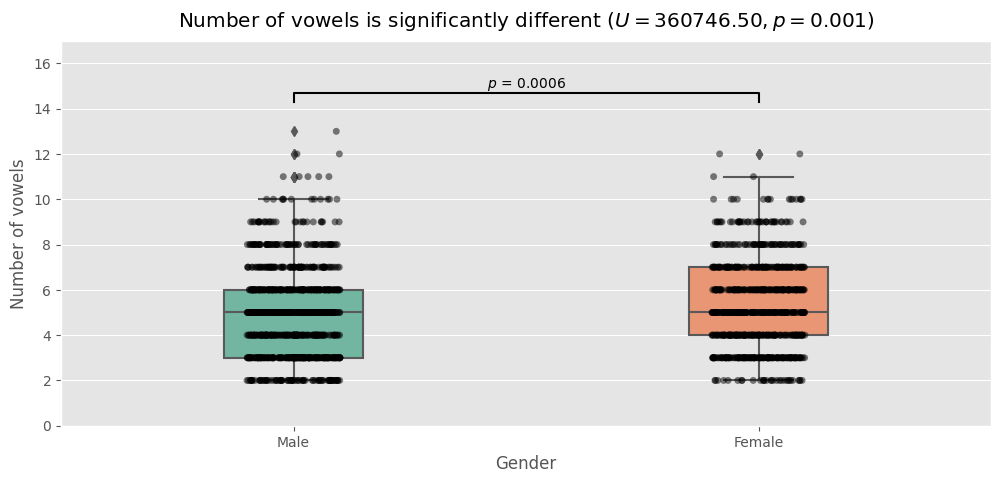

In [350]:
# prepare data
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['vowelcount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['vowelcount']

# perform Mann-Whitney U 
stat, p_value = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# visualize the difference
plt.figure(figsize=(12, 5))
sns.boxplot(x='gender', y='vowelcount', data=explore_df, palette='Set2', width=0.3)
sns.stripplot(x='gender', y='vowelcount', data=explore_df, color='k', alpha=0.5, jitter=True)

# calculate the vertical offset for annotations
max_y = max(explore_df['vowelcount'])
offset = max_y * 0.1  

# determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # vertical position of the bracket
h = offset * 0.3    # height of the bracket
col = 'k'           # color of the line and text

# Add a bracket-style line
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'Number of vowels is significantly different ($U={stat:.2f}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Gender')
plt.ylabel('Number of vowels')
current_labels = plt.gca().get_xticklabels()    # get current y-tick labels
plt.gca().set_xticklabels(['Male', 'Female'])   # replace with new labels
plt.ylim(0, 17)
plt.show()

In [351]:
# calculate Mann-Whitney U statistic
u_statistic, _ = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

pd.DataFrame({'U_stat': stat, 
              'p-value': p_value,
              'effect_size': effect_size,
              '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]}).round(3)

,U_stat,p-value,effect_size,95%CI
0,360746.5,0.001,-0.047,"[-0.073, -0.019]"


**Note**: Despite a significant difference between male and female names based on their vowel counts, the practical significance is minor ($r$ = -0.047, 95% CI = \[-0.074, -0.02]).

#### **2.2.6 Is the number of consonants across gender significantly different?**

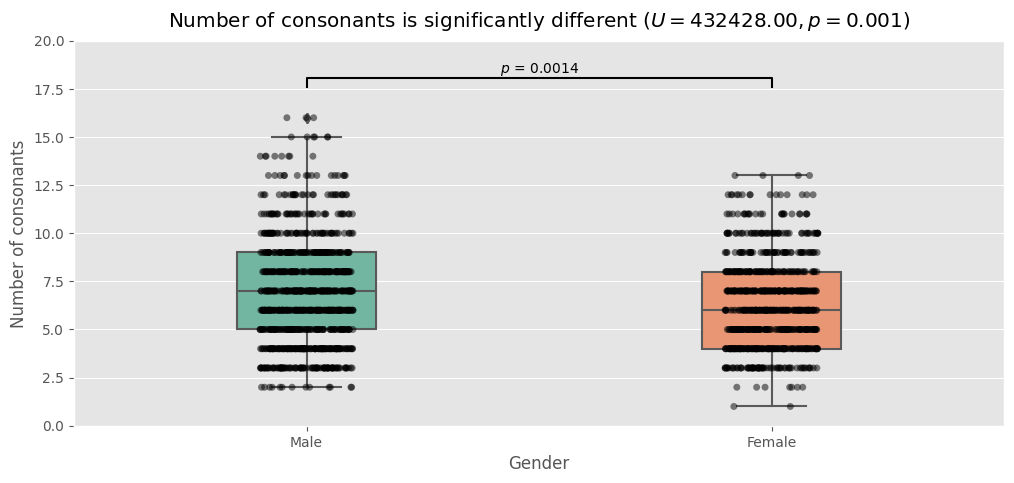

In [352]:
# prepare data
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['conscount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['conscount']

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(data_group1, data_group2)

# visualize the difference
plt.figure(figsize=(12, 5))
sns.boxplot(x='gender', y='conscount', data=explore_df, palette='Set2', width=0.3)
sns.stripplot(x='gender', y='conscount', data=explore_df, color='k', alpha=0.5, jitter=True)

# calculate the vertical offset for annotations
max_y = max(explore_df['conscount'])
offset = max_y * 0.1  # 10% of the y-axis range as an offset

# determine positions for the bracket
x1, x2 = 0, 1
y = max_y + offset  # vertical position of the bracket
h = offset * 0.3    # height of the bracket
col = 'k'           # color of the line and text

# add a bracket-style line
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f'$p$ = {p_value:.4f}', ha='center', va='bottom', color=col)

plt.title(f'Number of consonants is significantly different ($U={stat:.2f}, p={p_value:.3f}$)', pad=10)
plt.xlabel('Gender')
plt.ylabel('Number of consonants')
current_labels = plt.gca().get_xticklabels()    # get current y-tick labels
plt.gca().set_xticklabels(['Male', 'Female'])   # replace with new labels
plt.ylim(0, 20)
plt.show()

In [353]:
# split data by gender
gender_types = explore_df['gender'].unique()
data_group1 = explore_df[explore_df['gender'] == gender_types[0]]['conscount']
data_group2 = explore_df[explore_df['gender'] == gender_types[1]]['conscount']

# calculate Mann-Whitney U
u_statistic, _ = mannwhitneyu(data_group1, data_group2, alternative='two-sided')

# calculate effect size
n1, n2 = len(data_group1), len(data_group2)
effect_size = rank_biserial_effectsize(u_statistic, n1, n2)

# calculate bootstrap confidence intervals
ci_lower, ci_upper = bootstrap_ci(data_group1, data_group2)

pd.DataFrame({'U_stat': stat, 
              'p-value': p_value,
              'effect_size': effect_size,
              '95%CI': [[round(ci_lower, 3), round(ci_upper, 3)]]}).round(3)

,U_stat,p-value,effect_size,95%CI
0,432428.0,0.001,0.044,"[0.018, 0.071]"


**Note**
- Apparently, similar to the number of vowels in names, the number of consonants in male and female names are significantly different with *p* < 0.05. Although this result is statistically significant, the effect size is small. Therefore, the practical significance of this finding is limited with effect size of 0.044. 
- With such small effect size, the difference in consonant counts may not matter much. It is not something that will make a noticeable impact in real-world situations.

### **2.3 Summary**
The objectives of Section 2 is twofold: data preparation, including cleaning, and data analysis. Data preparation serves to investigate the cleanliness of the dataset and handle some problems which are crucial for the modeling process, particularly duplicates. Data analysis is more an quantitative linguistic exploration on the names by considering number of words (names separated by white spaces), number of characters, number of vowels and consonants. While this section does not inform anything to the modeling process, the short linguistic analysis provides an added value of names in gaining an understanding. In addition, based on the series of statistical tests on the difference across gender statuses, the differences in names based on limited linguistic features practically do not matter much. 

## **3 Predictive Modeling**
This section involves a predictive modeling technique to guess whether someone's gender is male or female based on their full name. As informed by the previous section, some data-related problems, especially for dplicates, have been handled so the next step can directly be done here. Other than duplicates, the dataset contains punctuation marks which require explicit handling in the modeling process. Previously, even though punctuation removal has been done for an analysis purpose, this text cleaning step must be done again in the modeling process. The reason is because earlier, the punctuation removal was performed on different dataset (copy of the dataset) for a different purpose. Additionally, this text cleaning process should be put in the machine learning model to streamline the whole machine learning process.

Section 3 is outlined as follows. Before moving on to the modeling process, ML data preparations will be carried out. This process includes creation of a text cleaning object which later will be assembled in the ML pipeline. Data splitting and pipeline creation, including putting the different algorithms, are also covered here. Second, after the data is ready for being fed to the algorithms, I will compare different models based on several performance metrics, namely F1, recall, precision, and ROC-AUC, for performance evaluation (explained below). Based on this comparison, three top models will be chosen and tested against testing data. The best model will be tuned and selected as the final model.
- F1 (also called F-measure): a model evaluation technique which takes both precision and recall into account equally (harmonic mean, no weighing). 
$$
\text{F1 score} = \frac{2\times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$
- Precision: proportion of predicted positive. For this reason, the formula only involves positive instance categories. 
    - Just for the record, true positive (TP) in the formula means the model's prediction is positive, and the actual is also positive. For example, a model predict someone's gender Male (alias 1, hereby "positive") and the actual gender is also (Male).
    - True negative is when both model prediction and the actual instances are negative. For example, the model predicts someone's gender Female (alias 0, hereby "negative").
    - False positive is when the model's prediction is positive (Male) while actually negative (Female).
    - False negative refers to a condition when the prediction is negative (Female) but actually the gender is positive (Male).
    - Here, positive and negative have nothing to do with good or bad. These are common terms used to denote types of model's predictions for simplicity.
$$
\text{Precision} = \frac{TP}{TP+FP}
$$
- Recall: proportion of actual positive (retrieving relevant instance only). It is calculated by dividing true positive by the sum of true positives and false negatives.
$$
\text{Recall} = \frac{TP}{TP+FN}
$$
- ROC-AUC (Receiver Operating Characteristic-Area Under the Curve): model's ability to distinguish between positive and negative instances.

While these four evaluation metrics are all useful, the main evaluation metric to assess the performance of a model is F1. It provides a balanced measure incorating different errors (false positives and false negatives). Unlike precision and recall which measure performance in isolation, F1 offers a single metric that reflects overall effectiveness. Additionally, while ROC-AUC offers insights into model discrimination ability, it does not capture the trade off between precision and recall. Therefore, F1 provides a more relevant evaluation metric.

### **3.1 Data Preparation**

In [354]:
# remove punctuations
class RemovePunctuation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.Series):
            return X.apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
        elif isinstance(X, list):
            return pd.Series(X).apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
        else:
            raise ValueError("Input should be a series or list of strings.")

**Note**: The object above is used to clean column `name` from punctuation marks. The idea is any elements in `string.punctuation` will be removed from the `name`. It is important to note that I only setup this object since the all names are already in lowercase. Other text cleaning techniques such as number and URL will be handled in the user input (in Streamlit app), not in the model's pipeline.

In [355]:
# split the data
X = df['name']
y = df['gender'].apply(lambda x: 1 if x == 'm' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Sample size: {df.shape[0]} rows and {df.shape[1]} cols')
print(f'- X_train dimension: {X_train.shape[0]}')
print(f'- y_train lenght: {len(y_train)}')
print(f'- X_test dimension: {X_test.shape[0]}')
print(f'- y_test lenght: {len(y_test)}')

Sample size: 1796 rows and 2 cols
- X_train dimension: 1436
- y_train lenght: 1436
- X_test dimension: 360
- y_test lenght: 360


In [356]:
# create preprocessor pipelinee
preprocessor = Pipeline([
    ('remove_punctuation', RemovePunctuation()),
    ('vectorizer', CountVectorizer(analyzer='char_wb', ngram_range=(3, 3)))
])

display(preprocessor)

Pipeline(steps=[('remove_punctuation', RemovePunctuation()),
                ('vectorizer',
                 CountVectorizer(analyzer='char_wb', ngram_range=(3, 3)))])

**Note**
- After splitting dataset into training and testing sets, I build a preprocessor involving the class `RemovePunctuation` to clean the name from punctuation marks which are common in Indonesian names, especially those with Arabic origins. 
- In addition to the class, I also include `CountVectorizer` to compute the number of character n-gram vectors in the name. As can be seen the parameter `analyzer` is specified in the class, meaning that the n-gram used here is character n-grams restricted by a word boundary (space). Specifying this character n-grams allows me to extract a string of characters for each name component (n-grams for first, middle (if any), and last name). 
- The 3-character n-gram is specified in the parameter here because this range of n-grams can captures patterns in words that are too short to be identified by larger n-gram span yet more meaningful than single or bigrams. 

In [357]:
# fit and transform X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# convert the sparse matrix to a DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), 
                                      columns=preprocessor.named_steps['vectorizer']
                                      .get_feature_names_out())

# add the original text column back to the DataFrame
X_train_transformed_df.index = X_train.values  

# display the output with the original text
display(X_train_transformed_df.head())

,a,aa,ab,ac,ad,ae,af,ag,ah,ai,...,zri,zub,zuh,zuk,zul,zun,zwa,zwi,zza,zzu
siti arbaiyah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
j. supartono,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
jarwo pratitis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
reysa hastarimasuci,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alwan supangat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Note**
- The output above demonstrates how the preprocessor pipeline extracts all 3-character n-grams from the names.
- One or two character n-grams appear in the feature names even though the character span was previously set to 3. But this output is normal anyway since there are white spaces around the feature name. For example, when a name consists of multiwords, and the middle name is shortened into its initial, then the preprocessor will only capture a single character.
- The seemingly 2-character name components, e.g., *aa*, *ab*, and *ac*, actually consists of three characters but since its position is in the end or the beginning of the name (if middle or last name), the white spaces are captured too.
- I keep the output this way because this white space can inform the position of the string of letters later. 

In [358]:
# define scoring metrics
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# specify models for comparison
classifiers = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)), 
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42))
]

# assemble everything in a pipeline
pipelines = [(name, Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])) for name, model in classifiers]

In [359]:
# use stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Note**: In the code above, I defined scorers, algorithms, pipeline, and cross-validation technique. These all components will be used during the modeling process, especially for comparing performance of different models. The stratified k-fold cross-validation there is used to ensur each fold (*k*) of the data has a similar distribution of target classes. This cross-validation technique is done iteratively by training the model on first fold and tested on the remaining folds. This process continues until the last fold.

### **3.2 Model Comparison**

In [360]:
# evaluate each model
results = []
for name, pipeline in pipelines:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_results = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}"] = np.mean(cv_results['test_score'])
        scores[f"{metric_name}_sd"] = np.std(cv_results['test_score'])
    end_time = time.time()
    training_time = end_time - start_time
    scores['training_time'] = training_time
    results.append((name, scores))

# DataFrame for comparison
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1).round(3)
results_df = results_df.set_index('Model')

In [361]:
# Display results
results_df.sort_values(by='f1', ascending=False) 

,f1,f1_sd,precision,precision_sd,recall,recall_sd,roc_auc,roc_auc_sd,training_time
Model,,,,,,,,,
Support Vector Machine,0.934,0.006,0.929,0.010,0.939,0.020,0.924,0.005,2.293
Logistic Regression,0.931,0.010,0.930,0.012,0.932,0.023,0.921,0.009,20.026
Random Forest,0.925,0.004,0.933,0.011,0.917,0.010,0.916,0.006,0.883
XGBoost,0.918,0.005,0.919,0.021,0.918,0.018,0.907,0.009,0.489
CatBoost,0.914,0.010,0.908,0.014,0.921,0.030,0.900,0.008,17.202
Gradient Boosting,0.908,0.012,0.888,0.026,0.929,0.022,0.888,0.017,0.716
Decision Tree,0.894,0.004,0.894,0.017,0.895,0.022,0.879,0.005,0.178
AdaBoost,0.894,0.010,0.893,0.020,0.896,0.013,0.879,0.014,0.469
K-Nearest Neighbors,0.855,0.020,0.902,0.009,0.813,0.035,0.850,0.016,0.197


**Note**
- The dataframe summarizes the results of the model comparison along with different performance metrics (means) and their standard deviations (SDs). SDs are used here to indicate the consistecy of each model's performance in all folds (*k* = 5).
- As can be seen, Support Vector Machine (SVM) model has the highest F1 score of 0.934 $\pm$ 0.006, along with recall, precision, and ROC-AUC over 0.90, indicating high performance in predicting and discriminating different gender statuses based on personal names.
- In addition to SVM, Logistic Regression and Random Forest models appear to have significantly high performance too. Considering their high performance, these three-top models will be used for hyperparameter tuning. However, before tuning the top models during the comparison, I will build these three models first.

### **3.3 Model Building**

In [362]:
# specify top-3 models
clf_SVM = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', SVC(probability=True))
])
clf_LR = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])
clf_RF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# fit each model on training set
clf_SVM.fit(X_train, y_train)
clf_LR.fit(X_train, y_train)
clf_RF.fit(X_train, y_train)

# evaluate each model on validation set
y_pred_SVM = clf_SVM.predict(X_test)
y_pred_LR = clf_LR.predict(X_test)
y_pred_RF = clf_RF.predict(X_test)

In [363]:
# define a function to compute metrics
def compute_metrics(y_true, y_pred, y_prob=None):
    metrics = {
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }
    if y_prob is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    return metrics

# evaluate classifiers
y_prob_SVM = clf_SVM.predict_proba(X_test)[:, 1]
metrics_SVM = compute_metrics(y_test, y_pred_SVM, y_prob_SVM)
y_prob_LR = clf_LR.predict_proba(X_test)[:, 1]
metrics_LR = compute_metrics(y_test, y_pred_LR, y_prob_LR)
y_prob_RF = clf_RF.predict_proba(X_test)[:, 1]
metrics_RF = compute_metrics(y_test, y_pred_RF, y_prob_RF)

# compile metrics in df
untuned_model_testing = pd.DataFrame({
    'Model': ['SVM', 'Logistic Regression', 'Random Forest'],
    'F1 Score': [metrics_SVM['f1'], metrics_LR['f1'], metrics_RF['f1']],
    'Precision': [metrics_SVM['precision'], metrics_LR['precision'], metrics_RF['precision']],
    'Recall': [metrics_SVM['recall'], metrics_LR['recall'], metrics_RF['recall']],
    'ROC-AUC': [metrics_SVM.get('roc_auc', 'N/A'), metrics_LR.get('roc_auc', 'N/A'), metrics_RF.get('roc_auc', 'N/A')]
}).round(3)
untuned_model_testing.set_index('Model', inplace=True)

# show results
display(untuned_model_testing)

,F1 Score,Precision,Recall,ROC-AUC
Model,,,,
SVM,0.944,0.935,0.954,0.978
Logistic Regression,0.934,0.925,0.944,0.972
Random Forest,0.931,0.924,0.938,0.972


**Note**: The output shown above displays the performance metrics of top-three models against unseen data. In comparison to the performance in the training data during the model comparison in which the models were trained on the training set and tested using the validation set, the output shown here indicates slight differences. The models' performance on testing set is higher than the performance in the training set. This difference albeit small is desirable because the models are expected to be able to generalize their learning to unseen data.

### **3.3 Hyperparameter Tuning**
After building the models and evaluating the performance of the three models, the top model is chosen for hyperparameter tuning. Tuning a model is expected to find an optimal combination of hyperparameters (predefined argument values) which in result can improve the model's performance. The combination is searched by using grid search technique (`GridSearchCV`). Unlike random search technique in hyperparameter tuning, grid search searches best combination of pre-defined hyperparameters for a model or estimator *exhaustively*. It seeks over every possible combination of hyperparamters and find the best combination.

In [364]:
# define parameter grid
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# create GridSearchCV
grid_svm = GridSearchCV(clf_SVM, param_grid_svm, cv=10, scoring='f1', n_jobs=-1)

# fit the grid search
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('remove_punctuation',
                                                         RemovePunctuation()),
                                                        ('vectorizer',
                                                         CountVectorizer(analyzer='char_wb',
                                                                         ngram_range=(3,
                                                                                      3)))])),
                                       ('classifier', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf']},
             scoring='f1')

In [365]:
# show all elements
pd.options.display.max_colwidth = None

best_index = grid_svm.best_index_
std_test_score = grid_svm.cv_results_['std_test_score'][best_index]

# store tuned version result
exp1_tuned_training = pd.DataFrame({
    'Model': ['SVM'],
    'Best Parameters': [grid_svm.best_params_,],
    'Best F1 Score': [grid_svm.best_score_,],
    'Std': [std_test_score,]
}).round(3)

display(exp1_tuned_training)

,Model,Best Parameters,Best F1 Score,Std
0,SVM,"{'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}",0.941,0.007


**Note**
- The best estimator, i.e., Support Vector Machine Classifier (SVC), performs most optimal when the regularization parameter (`C`) is 0.1, with radial basis function (RBF) kernel coefficient (`gamma`) of `scale`, and kernel fnction (`kernel`) of `linear`. Here are what these hyperparams do:
    - The regularization parameter (`C`) controls the trade-off between maximizing the margin and minizing the misclassifications. When it is set higher value, the margin (distance between hyperplane and closest dta points) will be narrower. 
    - The kernel function (`kernel`) determines how the data will be mapped into a multidimensional space. Linear hyperparameter is suitable for linearly separable data. 
    - The RBF kernel parameter (`gamma`) controls the variance of the RBF kernel. 
- As can be seen using the hyperparameters, the estimator can achieve the best F1 score of 0.941 $\pm$ 0.007 in the training data. It is noteworthy that "best" in the F1 score here is the highest score of the estimator can get with 10 cross-validation folds.

In [366]:
# assuming grid_svm is the fitted GridSearchCV object for SVM
best_SVM = grid_svm.best_estimator_  
y_pred_SVM = best_SVM.predict(X_test) 

# compute metrics
tuned_model_testing = {
    'F1 Score': f1_score(y_test, y_pred_SVM),
    'Precision': precision_score(y_test, y_pred_SVM),
    'Recall': recall_score(y_test, y_pred_SVM),
    'Accuracy': accuracy_score(y_test, y_pred_SVM),
    'ROC-AUC': roc_auc_score(y_test, best_SVM.predict_proba(X_test)[:, 1])
}

# convert to df
tuned_model_testing = pd.DataFrame([tuned_model_testing]).round(3)
display(tuned_model_testing)

,F1 Score,Precision,Recall,Accuracy,ROC-AUC
0,0.946,0.944,0.949,0.942,0.974


**Note**: As shown previously, the performance of the SVC using training data is 0.941 while its performance in testing data is 0.946 (F1). Higher performance metric in the unseen data is desirable. It means that the model can generalize its learing to the unseen data.

In [367]:
# compare untuned vs tuned model
display(untuned_model_testing.iloc[[0], :],
        tuned_model_testing)

,F1 Score,Precision,Recall,ROC-AUC
Model,,,,
SVM,0.944,0.935,0.954,0.978


,F1 Score,Precision,Recall,Accuracy,ROC-AUC
0,0.946,0.944,0.949,0.942,0.974


**Note**
- When comparing the untuned (original) to the tuned model, it is apparent that despite increase in F1 score and precision, the increase is not significant. This slight increase might suggest that the model has actually been optimal for making predictions on the unseen data.
- While the ROC-AUC score drops slightly in the tuned version, I will still select the tuned version because the F1 score is higher. To note that ROC-AUC is a metric to evaluate the model's discriminatory power in the binary classification task in the context of this project.

### **3.4 Final Model**
After obtaining the best model, I will finalize the model by refitting the model using the most optimal hyperparameters into the traning set. Afterwards, I will look into the classification report to evaluate how well the model performs in each class (class 1: Male and class 0: Female) and assess the overall performance (e.g., using accuracy, macro-average, and micro-average).

In [368]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, C=0.1, gamma='scale', kernel='linear'))
])

# fit the pipeline on the training data
final_model.fit(X_train, y_train)

# predict on the test set
y_pred_test = final_model.predict(X_test)

# predict probability
y_prob_test = final_model.predict_proba(X_test)[:, 1]

In [369]:
display(pd.DataFrame(compute_metrics(y_test, y_pred_test, y_prob_test), index=[0]).round(3))
print(classification_report(y_test, y_pred_test))

,f1,precision,recall,roc_auc
0,0.946,0.944,0.949,0.974


              precision    recall  f1-score   support

           0       0.94      0.93      0.94       165
           1       0.94      0.95      0.95       195

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360



**Note**
- Overall, the model performs well according to the accuracy, macroaverage, and weighted average whose all values are 94%. 
    - The accuracy metric evaluates the proportion of correct predictions, and here the model correctly predicted 94% of the testing samples. 
    - Macroaverage in this context is the average of precision, recall, and F1 score in both class 0 and 1. Higher the value is, the better the model performs.
    - Weighted average is also the average of the three metrics similar to macroaverage. The difference is that weighted average use weighing based on the number of sample (`support`) in each class. Larger number of support will have more weights to the performance.
- In addition to the overall performance metrics, the model's performance in different classes is also good. As can be seen, the scores exceeds 90%.

#### **3.4.1 ROC-AUC Curve**
Receiver Operating Characteristic - Area Under the Curve (ROC-AUC) is a way to evaluate a classifier's performance which considers the trade-off between true positive rate and false positive rate. Just for the records, below are the formulas for true positive rate (TPR) and false positive rate (FPR).
$$TPR = \frac{TP}{\text{Actual Positive}} = \frac{TP}{TP+FN}$$
$$FPR = \frac{FP}{\text{Actual Negative}} = \frac{FP}{TN + FP}$$

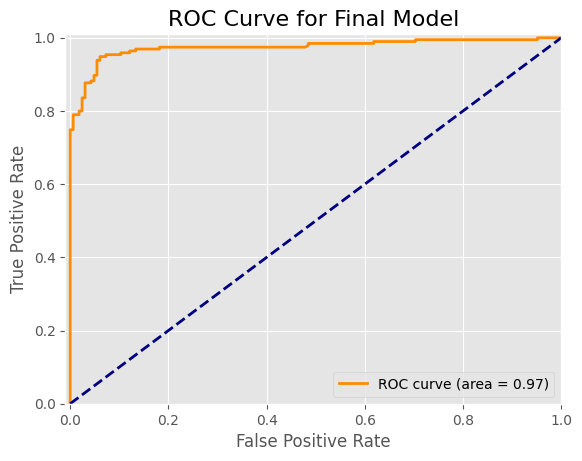

In [370]:
# plot ROC-AUC curve
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Final Model', fontsize=16)
plt.legend(loc="lower right")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.show()

**Note**: The area under the curve (AUC) is 0.97 (close to perfect score at 1.00). The high AUC means that the model is more likely to correctly distinguish between classes.

#### **3.4.2 Precision-Recall Curve**
Precision-recall curve evaluates the trade-off between precision and recall across different thresholds. A desirable model should have high precision and high recall at all thresholds. Visually, this condition can be detected from the location of the curve on the top right corner. The closer to the top right corner (high precision and high recall), the better the performance of a model is.

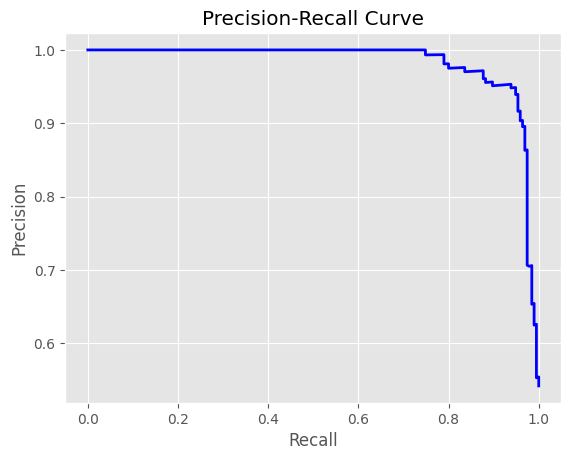

In [371]:
# plot PR curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
# plt.figure(figsize=(12, 7))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Note**: The <span style='color:blue'>blue</span> line is close to the top right corner, indicating that the model has high precision and high recall in spite of not perfect. The high precision and recall imply that the model is not only highly precise in identifying positive instance (precision) but also highly sensitive in identifying positive instance (recall).

#### **3.4.3 Learning Curve**
Learning curve is a visual evaluation technique to investigate how the model will perform once the training size increases. By doing this visual inspection, an overfitting problem can be detected. This overfitting problem can be seen by the large difference between the model's performance scores in training and cross-valdiation sets. Visually, when the gap between the lines of a training and cross-validation score (e.g., F1, recall, precision, or ROC-AUC), is narrow, the model is less likely to suffer from the overfitting problem. To note, overfitting occurs when a model performs well on the training set but does not perform equally well or better in the testing set. When the overfitting problem occurs, the model does not generalize its learning to the new data.

To more accurately explaining the learning curve, I also provide the numerical output of the model's learning process.

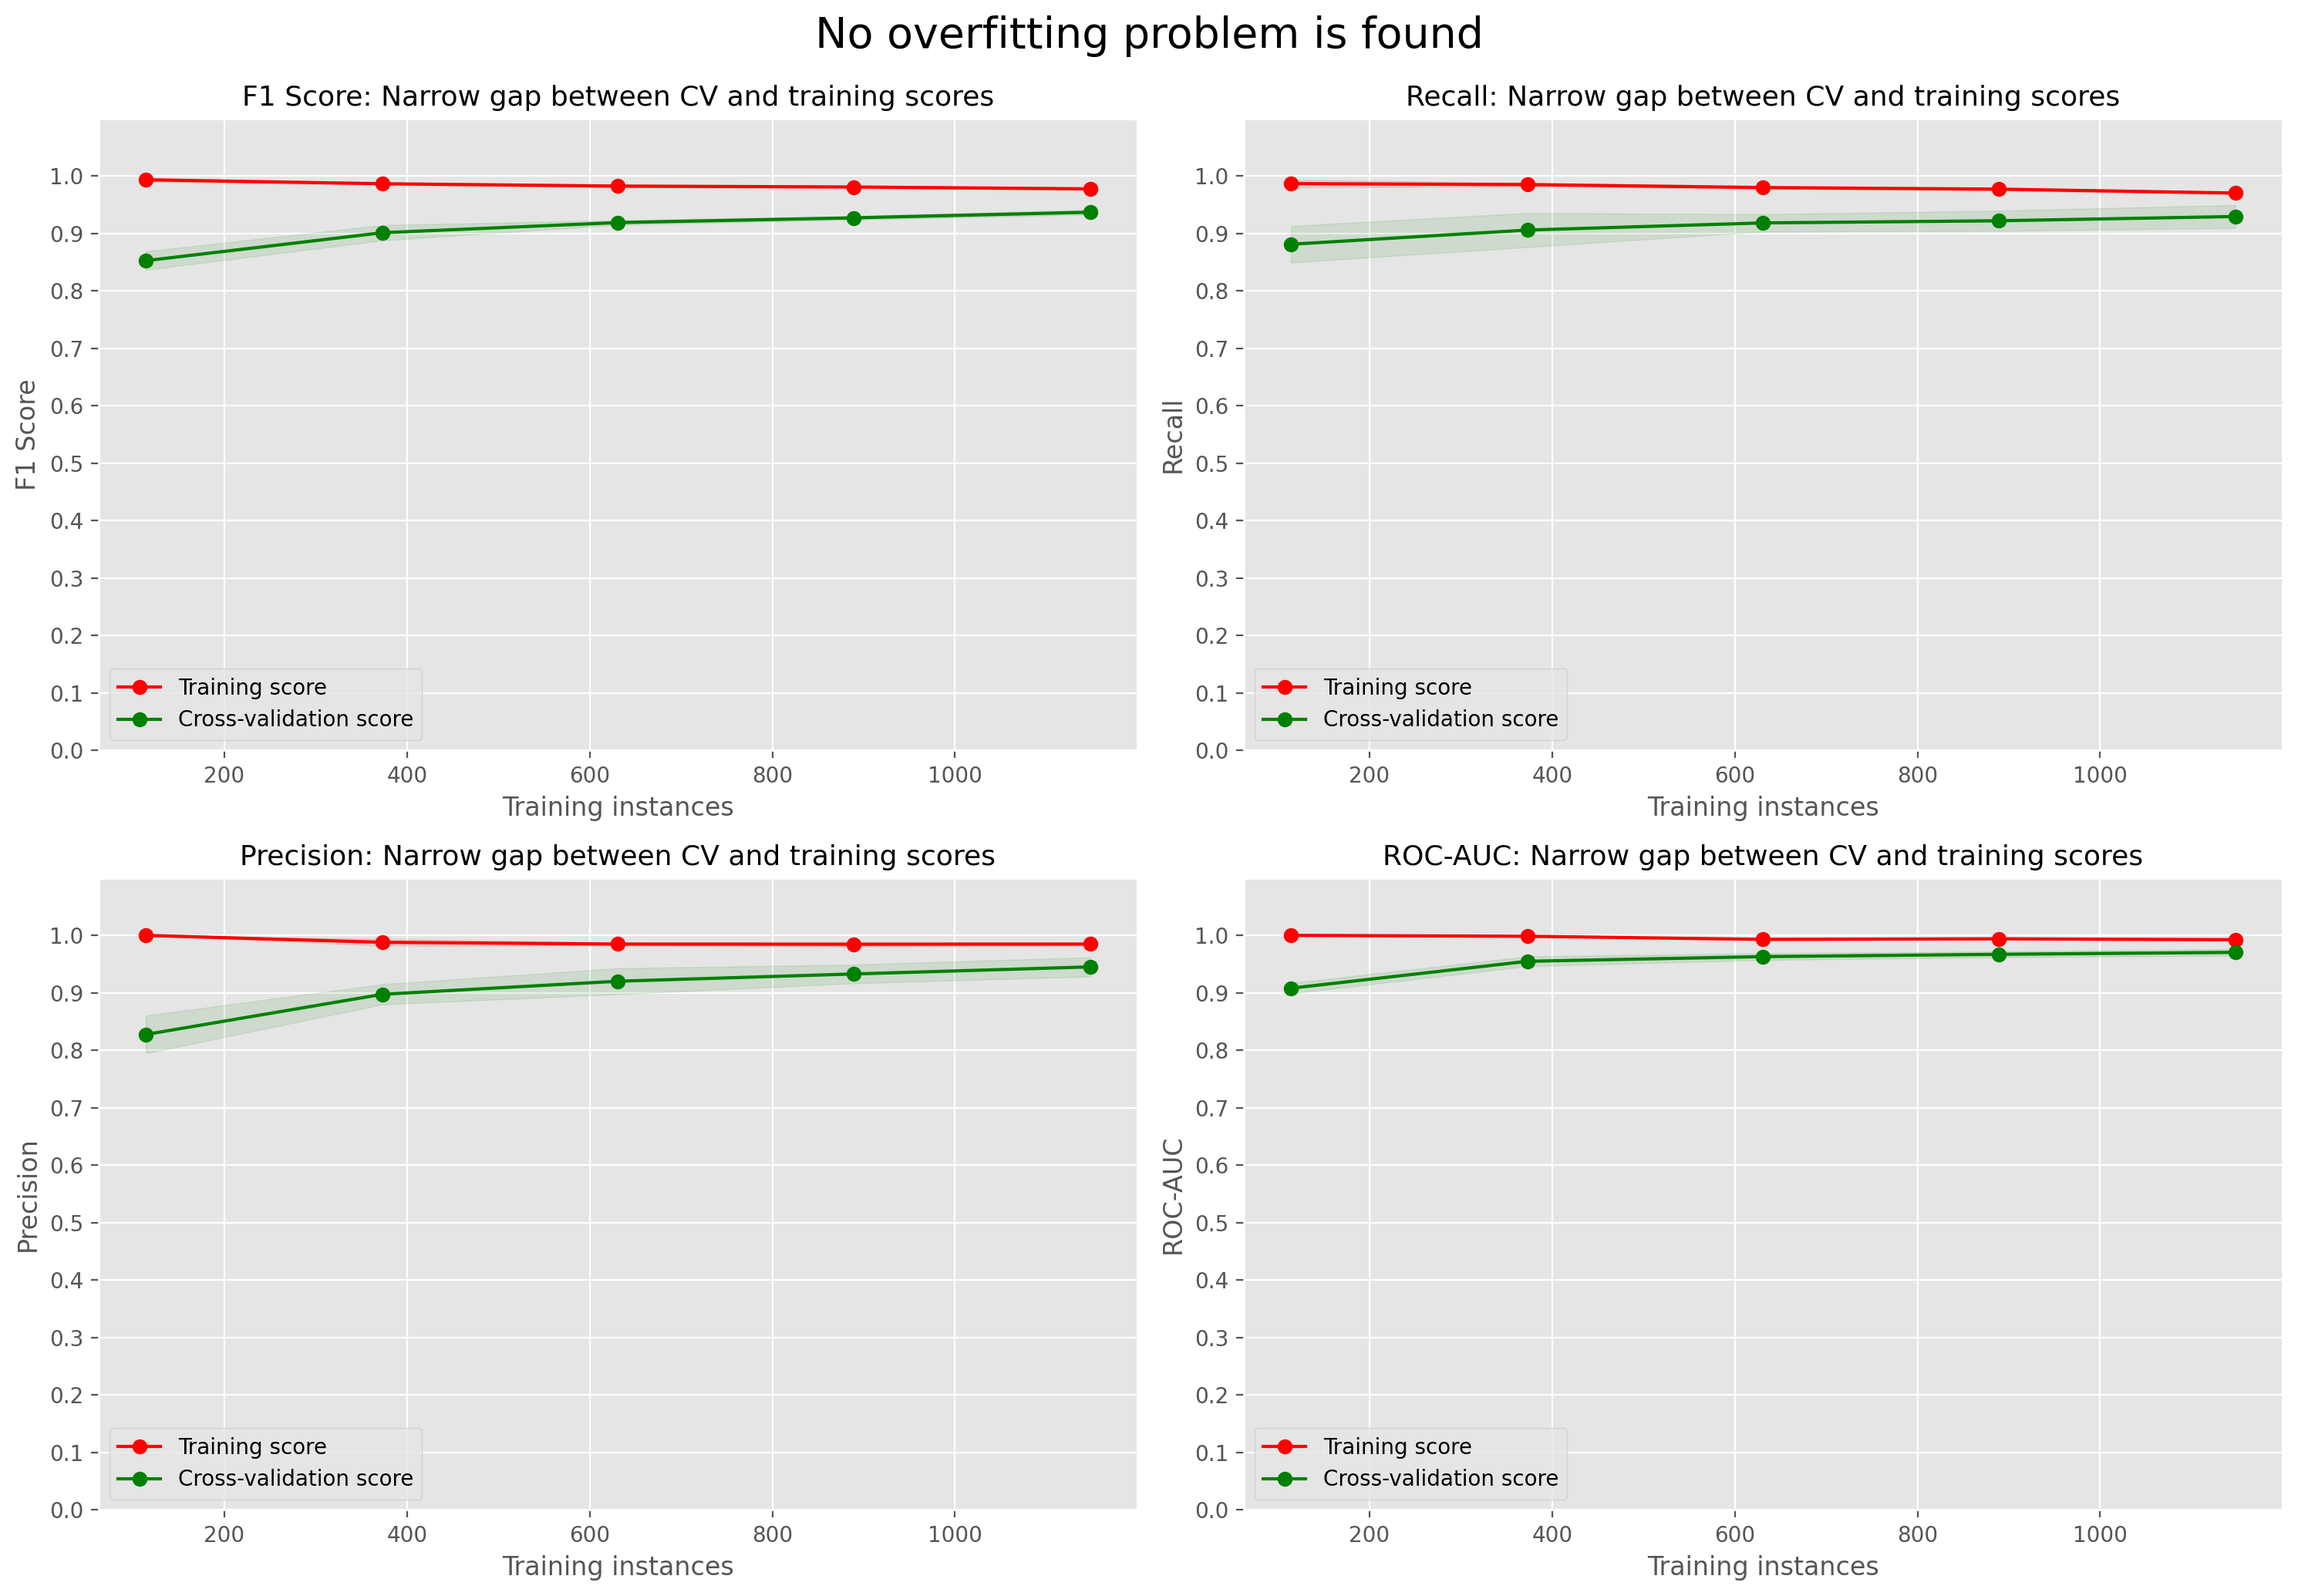

In [372]:
# define the metrics
metrics = {
    'F1 Score': 'f1',
    'Recall': 'recall',
    'Precision': 'precision',
    'ROC-AUC': 'roc_auc'
}

# init the figure and axis array
fig, axes = plt.subplots(2, 2, figsize=(15, 10), dpi=200)
axes = axes.ravel()  

# loop through each metric
for i, (metric_name, metric) in enumerate(metrics.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        final_model, X_train, y_train, cv=5, scoring=metric, n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    axes[i].set_xlabel('Training instances')
    axes[i].set_ylabel(metric_name)
    axes[i].set_title(f'{metric_name}: Narrow gap between CV and training scores', size=13)
    axes[i].legend(loc="best")
    axes[i].set_ylim(0, 1.1)
    axes[i].set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.suptitle('No overfitting problem is found', y=1.03, size=20)
plt.show()

In [373]:
# ROC-AUC (for adding details)
learning_curve_data = pd.DataFrame({
    'training_mean': train_scores_mean,
    'training_sd': train_scores_std,
    'testing_mean': test_scores_mean,
    'testing_sd': test_scores_std
}).round(3)
learning_curve_data['mean_diff'] = learning_curve_data['training_mean'] - learning_curve_data['testing_mean']
display(learning_curve_data)

,training_mean,training_sd,testing_mean,testing_sd,mean_diff
0,1.000,0.000,0.908,0.009,0.092
1,0.998,0.000,0.955,0.009,0.043
2,0.993,0.001,0.963,0.006,0.030
3,0.994,0.001,0.967,0.005,0.027
4,0.992,0.001,0.970,0.006,0.022


**Note**: The four learning curves above examine how the same model is evaluated using four performance metrics when the training data increases. In all curves, the model shows excellent performance: The gaps between training (<span style='color:red'>red line</span>) and cross-validation score lines (<span style='color:green'>green</span>) are narrow. For instance, the training mean score in ROC-AUC initially starts at 1.00 with the testing mean score of 0.90. The mean difference when the training size is around 100 instances is 0.092, and the mean difference is getting smaller once the training size is added. The narrow gap here suggests that the issue of overfitting does not occur in the model.

#### **3.4.4 Calibration Curve**
Calibration curve (or reliability curve) is a visual evaluation techniqe to tell whether the model's predicted probabilities align with its actual outcome. What I mean by actual outcome here is the fraction of positives. An ideal model is that with a diagonal line from the bottom left corner to the top right corner, suggesting a perfectly reliable model. For example, when the model predicts the probability of a name as male is 0.70, the actual probability is also 0.70.

In addition to the calibration curve to evaluate the overall reliability of the model, I will also provide Brier score and Expected Calibration Error (ECE) to gain a better understanding of the model's reliability and the calibration quality. In short, Brier score informs the overall quality of probabilistic predictions. A lower score after calibration means better reliability in the predictions. And ECE shows the mean difference between pred probabilities and actual outcomes. Similar to Brier score, a lower score, closer to 0, is desirable in this evaluation, meaning calibration process gives a better effect on the model.

$$
\text{Brier Score}=\frac{1}{N}\sum_{i=1}^N(p_i-y_i)^2
$$
- $p_i$: predicted probability of the positive class
- $y_i$: the actual binary outcome
- $N$: Total number of instances

These three evaluations on will be tested before and after the calibration process to check the calibration quality.

##### **3.4.4.1 Pre-Calibrated Model**

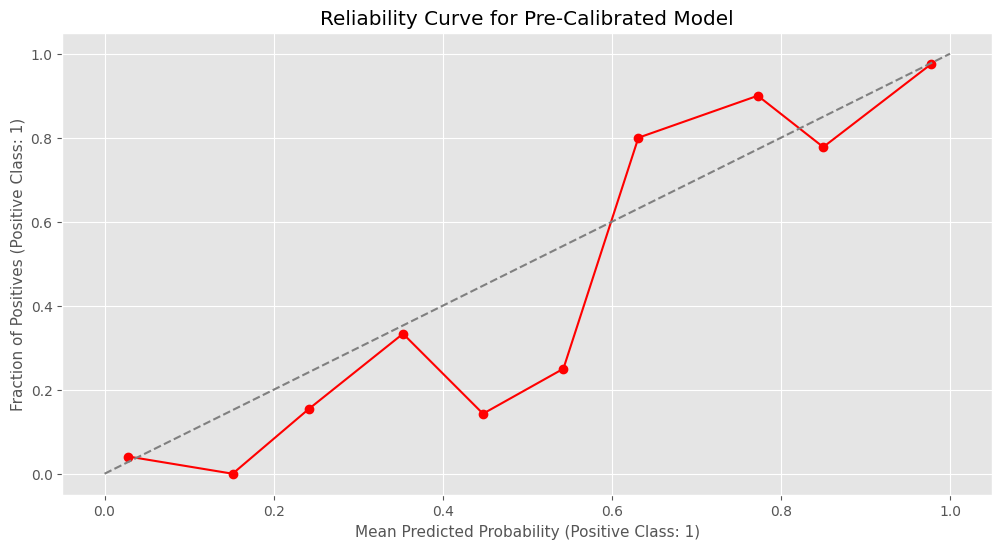

In [374]:
# predict probabilities on the test set
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# plot Reliability Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure(figsize=(12, 6))
plt.plot(prob_pred, prob_true, marker='o', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)', size=11)
plt.ylabel('Fraction of Positives (Positive Class: 1)', size=11)
plt.title('Reliability Curve for Pre-Calibrated Model')
plt.show()

In [375]:
precalibration_df = pd.DataFrame({
    'Predicted Probability': prob_pred,
    'Fraction of Positives': prob_true
})
print('Pre-calibration data:')
precalibration_df.round(2)

Pre-calibration data:


,Predicted Probability,Fraction of Positives
0,0.03,0.04
1,0.15,0.00
2,0.24,0.15
3,0.35,0.33
4,0.45,0.14
5,0.54,0.25
6,0.63,0.80
7,0.77,0.90
8,0.85,0.78
9,0.98,0.98


**Note**: In general, the probabilities are scattered around the diagonal (<span style='color:grey'>grey</span>) line but mostly the model is overconfident with its predictions. The overconfidence can be seen from the red line which is located below the diagonal line: The model's predicteed probability is higher than it should be. For example, when the model's predict a name as male (class 1) with predicted probability of 0.18, the actual probability is 0. Judging solely from this calibration curve, the model must be calibrated to increase the reliability of the model's prediction but before doing the calibration, I will look into the Brier score and the expected calibration error.

In [376]:
from sklearn.metrics import brier_score_loss

In [377]:
# build function to calculate ECE
def calculate_ece(y_true, y_prob, n_bins=10):
    # Compute calibration curve (fraction of positives, mean predicted value)
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')

    # Calculate ECE: sum of weighted absolute difference between predicted and true probabilities
    bin_width = np.histogram(y_prob, bins=n_bins)[0] / len(y_prob)
    ece = np.sum(bin_width * np.abs(prob_pred - prob_true))
    
    return ece

In [378]:
# compute brier score
y_true = y_test
y_prob_test = final_model.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_true, y_prob_test)
print("Brier score and ECE of pre-calibrated model:")
print(f"- Brier score: {brier_score:.4f}")

# compute ECE
ece_score = calculate_ece(y_true, y_prob_test, n_bins=10)
print(f"- ECE: {ece_score:.4f}")

Brier score and ECE of pre-calibrated model:
- Brier score: 0.0528
- ECE: 0.0342


**Note**
- The Brier score (0.053) and ECE (0.036) suggest overall accurate and reliable predictions even though as pointed earlier the model's prediction is overconfident.
- Afterwards, I will see how calibration can improve the model's reliability.

##### **3.4.4.2 Post-Calibrated Model**

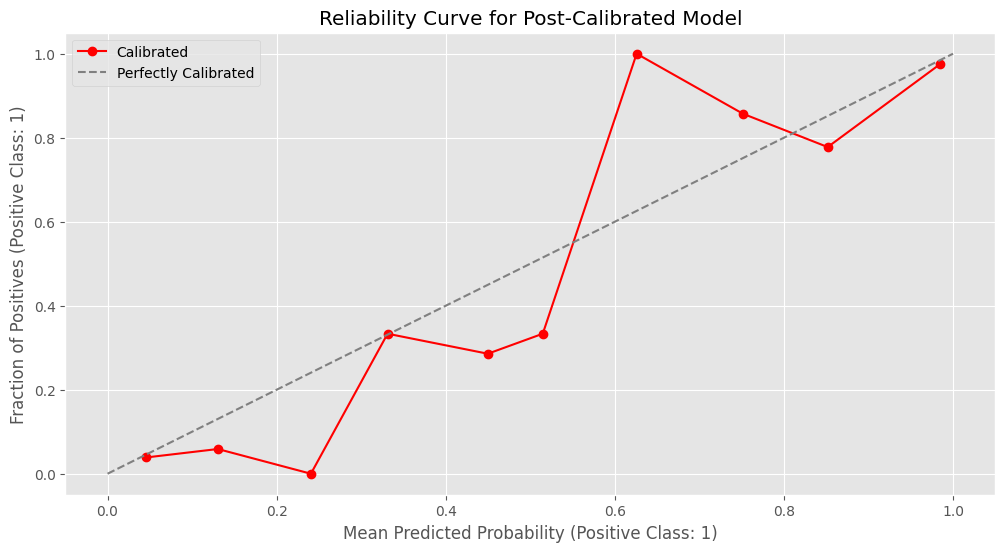

In [379]:
calibrated_clf = CalibratedClassifierCV(estimator=final_model, method='isotonic')
calibrated_clf.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = calibrated_clf.predict_proba(X_test)[:, 1]

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(12, 6))
plt.plot(prob_pred, prob_true, marker='o', color='red', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Reliability Curve for Post-Calibrated Model')
plt.legend(loc='best')
plt.show()


In [380]:
postcalibration_df = pd.DataFrame({
    'Predicted Probability': prob_pred,
    'Fraction of Positives': prob_true
})
print('Post-calibration data:')
postcalibration_df.round(2)

Post-calibration data:


,Predicted Probability,Fraction of Positives
0,0.05,0.04
1,0.13,0.06
2,0.24,0.00
3,0.33,0.33
4,0.45,0.29
5,0.51,0.33
6,0.63,1.00
7,0.75,0.86
8,0.85,0.78
9,0.99,0.98


**Note**: After the calibration, the model's prediction remains overconfident in some bins. When the model predicts the probability of class 1 0.24, the actual value is 0.00. To make sure the effect of calibration on the model's prediction reliability further, I will check the Brier score and ECE.

In [381]:
# compute brier score
y_true = y_test
y_prob_test = calibrated_clf.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_true, y_prob_test)
print("Brier score and ECE of post-calibrated model:")
print(f"- Brier score: {brier_score:.4f}")

# compute ECE
ece_score = calculate_ece(y_true, y_prob_test, n_bins=10)
print(f"- ECE: {ece_score:.4f}")

Brier score and ECE of post-calibrated model:
- Brier score: 0.0493
- ECE: 0.0261


**Note**
- Both Brier score and Expected Calibration Error show reduction after the model calibration process. This implies that the probabilistic predictions are slightly more accurate and better calibrated. 
- Judging from the `postcalibration_df` as an additional consideration, the model performs better acter calibration in terms of alignment between predicted probabilities and actual outcomes. 
- For these two reasons, I can conclude so far that the calibration process gives a good effect on the model's performance despite insignificant.
- To learn further about the mode's performance before and after calibration process, I will utilize confusion matrices. The desirable output is that after calibration, at least the model performs similar to the pre-calibrated version.

##### **3.4.4.3 Pre and Post-Calibration: Evaluation Matrix**

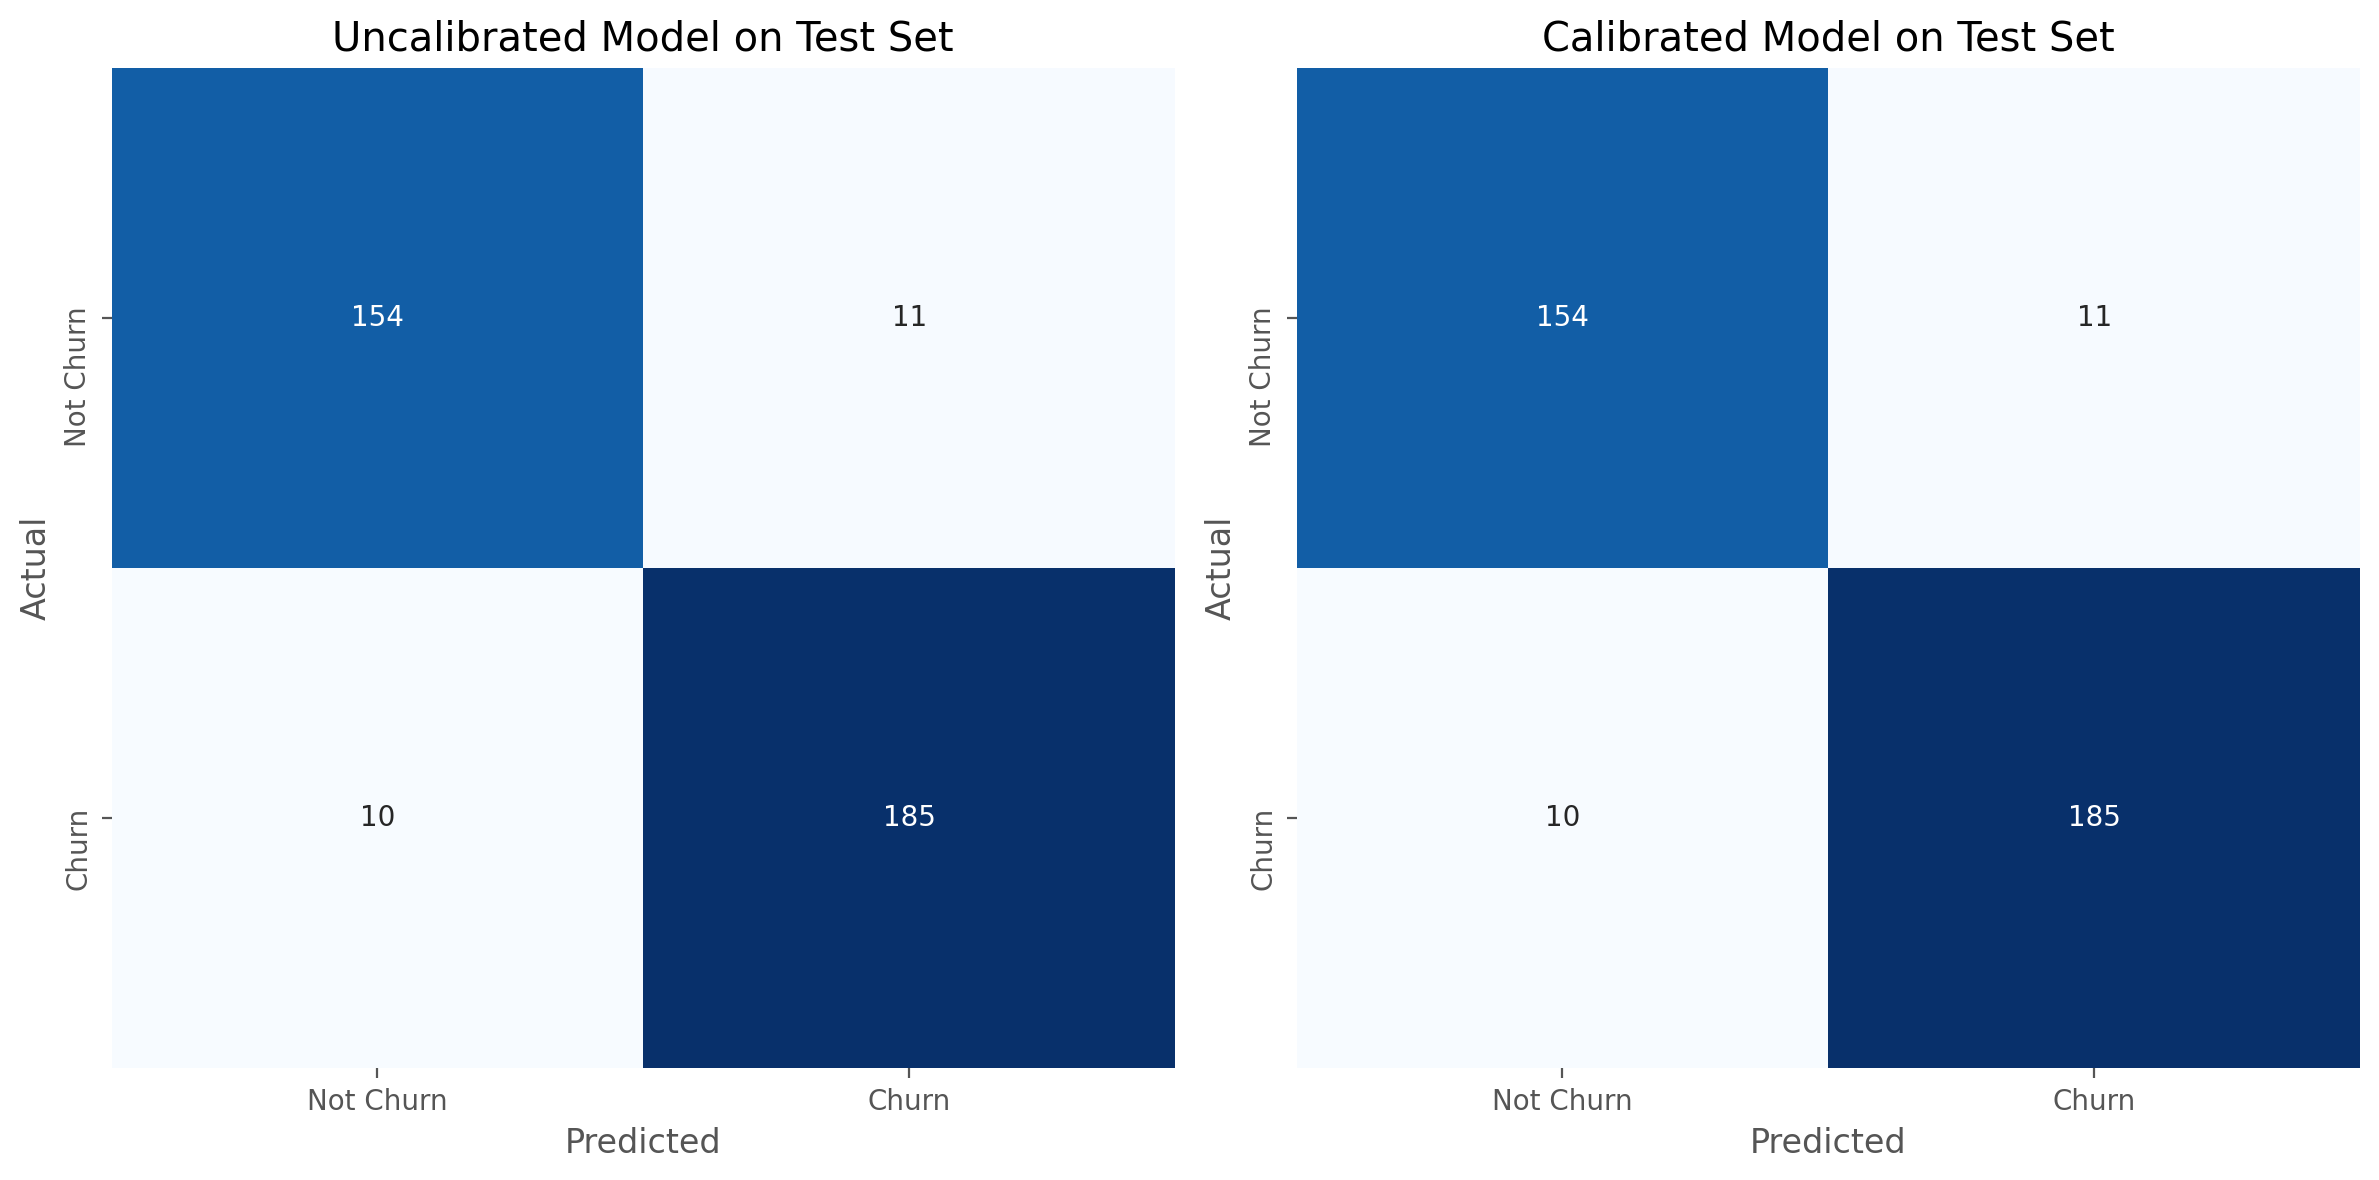

In [382]:
# Predict on the test set for both models
y_pred_test_uncal = final_model.predict(X_test)
y_pred_test_cal = calibrated_clf.predict(X_test)

# Compute confusion matrices
cm_uncal = confusion_matrix(y_test, y_pred_test_uncal)
cm_cal = confusion_matrix(y_test, y_pred_test_cal)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

# Plot confusion matrix for uncalibrated model
sns.heatmap(cm_uncal, annot=True, fmt='g', ax=axs[0], cmap='Blues', cbar=False)
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Uncalibrated Model on Test Set')
axs[0].set_xticklabels(['Not Churn', 'Churn'])
axs[0].set_yticklabels(['Not Churn', 'Churn'])

# Plot confusion matrix for calibrated model
sns.heatmap(cm_cal, annot=True, fmt='g', ax=axs[1], cmap='Blues', cbar=False)
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Calibrated Model on Test Set')
axs[1].set_xticklabels(['Not Churn', 'Churn'])
axs[1].set_yticklabels(['Not Churn', 'Churn'])

# Adjust layout
plt.tight_layout()
plt.show()

**Note**: After the calibratrion, the model shows no difference. While no changes in the confusion matrix, improved calibration metrics (ECE and Brier score) suggest better probability estimates so the calibrated version remains the top consideration.

#### **3.4.5 Global Explanation: Feature Importance**
Feature importance provides information on what features are most influential on the model's predictions. The feature importance can then explain the general behavior of the model in making predictions. For linear models, coefficient analysis can be used. In short, features with larger coefficients are more important in the model's predictions.

As the final model, namely Support Vector Machine, uses a linear kernel, coefficients can be used for feature importance. 

In [383]:
# get classifier and vectorizer
classifier = final_model.named_steps['classifier']
vectorizer = final_model.named_steps['preprocessor'].named_steps['vectorizer']

# check if the classifier has coefficients
if hasattr(classifier, 'coef_'):
    coefficients = classifier.coef_.toarray().flatten()  
    transformed_feature_names = vectorizer.get_feature_names_out()
    
    # ensure coefficients and feature names match in length
    if len(coefficients) == len(transformed_feature_names):
        # Create a DataFrame with the feature importance
        feature_importance = pd.DataFrame({
            'Feature': transformed_feature_names,
            'Importance': coefficients
        })

        # sort by absolute importance
        feature_importance['Absolute_Importance'] = feature_importance['Importance'].abs()
        feature_importance = feature_importance.sort_values(by='Absolute_Importance', ascending=False)

        # drop 'Absolute_Importance'
        feature_importance.drop(columns=['Absolute_Importance'], inplace=True)

        # display feature importance
        # display(feature_importance.head(10))
    else:
        print("Error: The number of coefficients does not match the number of features.")
else:
    print("Error: The classifier does not have a `coef_` attribute.")

In [384]:
# replace spaces with _ in the 'Feature' column
feature_importance2 = feature_importance.copy()
feature_importance2['Feature'] = feature_importance2['Feature'].str.replace(' ', '_')
feature_importance2 = feature_importance2.head(20)
feature_importance2 = feature_importance2.sort_values(by='Importance')

**Note**:As the white space is crucial to denote location of an n-gram, I will not remove it. Instead, the white space will be replaced by an underscore. The replacement of a white space in the 3-character n-grams with an underscore to indicate that if there any are n-grams seemingly consisting of one character due to white spaces, the underscore can make explicit the white space.

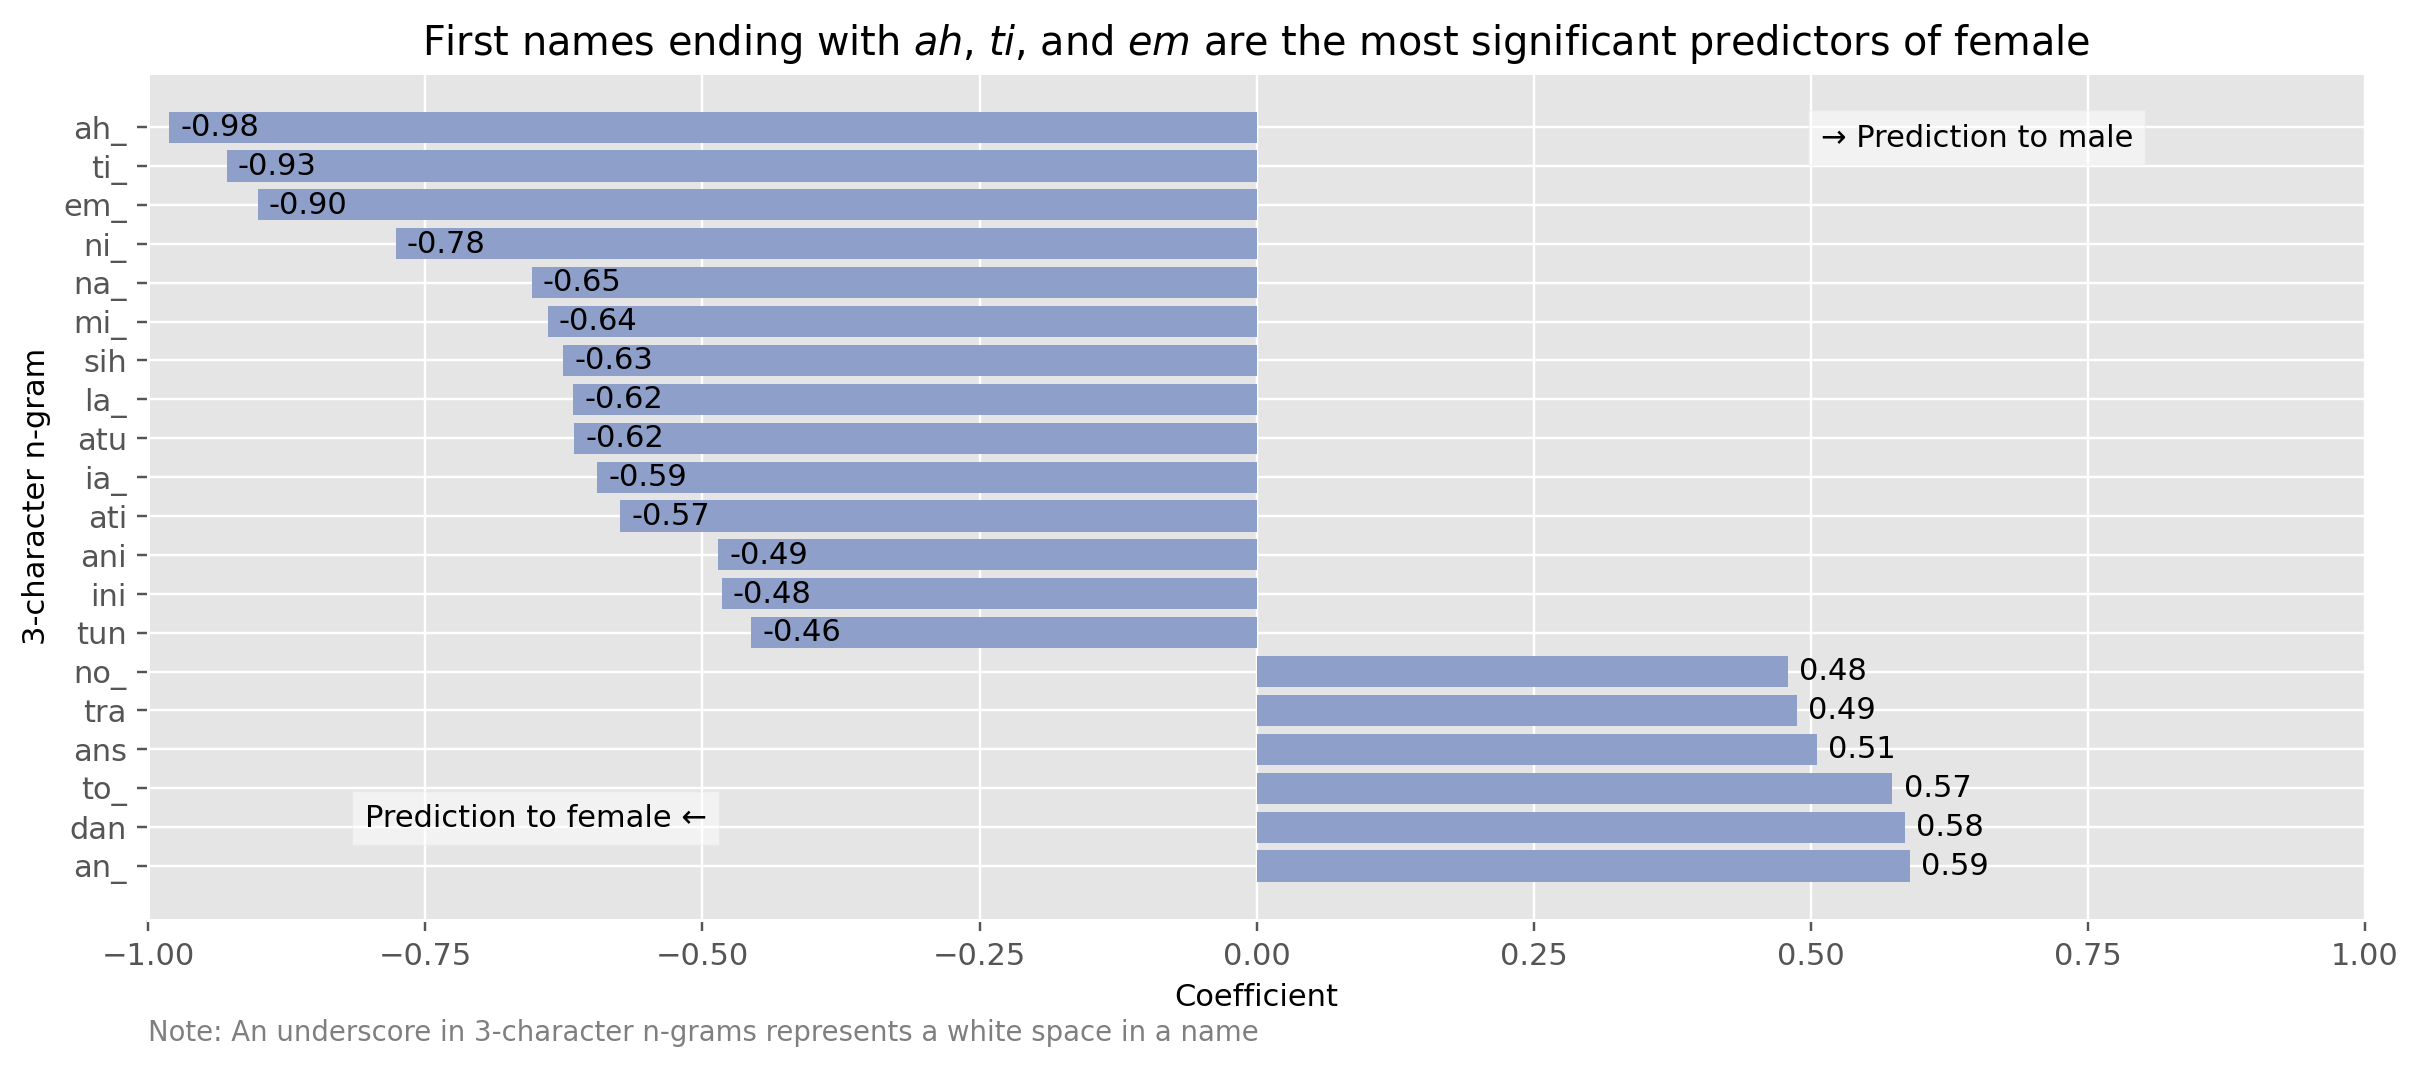

In [385]:
# visualize feature importance
plt.figure(figsize=(13, 5), dpi=220)
bars = plt.barh(feature_importance2['Feature'].head(20), 
                feature_importance2['Importance'].head(20), 
                color='#8e9fca')

# add data labels 
for bar in bars:
    plt.text(
        bar.get_width() + 0.01,                 # position slightly to the right of the bar end
        bar.get_y() + bar.get_height() / 2,     # vertical position at the center of the bar
        f'{bar.get_width():.2f}',               # format the coefficient value to 2 decimal places
        va='center',                            # vertical alignment
        ha='left',                              # horizontal alignment
        fontsize=10,                            
        color='black'                           
    )
plt.text(0.65, 0.5, '→ Prediction to male', 
         bbox=dict(facecolor='white', alpha=0.5), 
         fontsize=10, color='black', ha='center')
plt.text(-0.65, 18, 'Prediction to female ←',
         bbox=dict(facecolor='white', alpha=0.5), 
         fontsize=10, color='black', ha='center')
plt.text(-1, 23.5, 'Note: An underscore in 3-character n-grams represents a white space in a name', size=9, alpha=0.5)
plt.xlabel('Coefficient', size=10, color='black')
plt.title(f'First names ending with $ah$, $ti$, and $em$ are the most significant predictors of female', size=13)
plt.ylabel('3-character n-gram', size=10, color='black')
plt.gca().invert_yaxis()                       
plt.xlim(-1, 1)
plt.show()

**Note**
- The bar chart summarizes top-20 features most contributing to the model's predictions based on the coefficients. Some coefficients here are negatives, indicating their negative impact on the target variable. For example, as these features increasem the target variable decrease. Moreover, the magnitude of the coefficient represents the strength of the feature influence on the prediction. The larger the coeffient, regardless of their direction (negative or positive), the larger the effect of a feature is in the model's prediction.
- As shown on the visualization, *ah_*, *ti_*, and *em_* are top-three n-grams of names which have higher magnitude and negative values. These magnitude and direction mean that these three features are 3-character n-grams with the biggest predictive power in female.
- On the contrary, 3-character n-grams with the highest contribution to predictions to male are names ending with *an_* and *to_*. N-gram *dan* also appears to be among three most significant predictor of male.

##### **3.4.5.1 Is first name ending with *ah* more associated with female than male?**
Here, my intention is to check specific instances in the training set which are related to the most significant feature in the model's prediction shown above. This investigation provides a deeper understanding of why the the feature is important to the model to predict male or female.

In [386]:
# merge X_train and y_train
df_seen = pd.DataFrame({'name': X_train, 'gender': y_train})

# convert back binary values in target var
df_seen['gender'] = df_seen['gender'].apply(lambda x: 'm' if x == 1 else 'f')

In [387]:
# get all female names with first name ending with ah
ah_female_df = df_seen[(df_seen['name'].str.contains(r'^\w*ah\s', regex=True)) 
                       & (df_seen['gender'] == 'f')]
# check male names with first name ending with ah
ah_male_df = df_seen[(df_seen['name'].str.contains(r'^\w*ah\s', regex=True)) 
                     & (df_seen['gender'] == 'm')]
print(f'Female names ending with \'ah\': {len(ah_female_df)}')
display(ah_female_df.head())

print(f'Male names ending with \'ah\': {len(ah_male_df)}')
display(ah_male_df.head())

Female names ending with 'ah': 16


,name,gender
598,indah kurnia sari,f
1731,diah ayu safitri,f
823,aisyah giovani,f
126,indah rahmawati,f
41,zakiah nurviani,f


Male names ending with 'ah': 5


,name,gender
1243,lamsyah purba,m
957,abdullah afif azzuhri,m
412,aissyah dwi zhaskia,m
125,hijrah syahputra,m
22,ibnuyohanzah ahmad,m


**Note**
- As *ah_* includes a white space in the end of the n-gram, the white space indicates that the n-gram might be located in the end of the first or middle name. For this reason, I use `^\w*ah\s`. This regex pattern matches strings begins with zero or more letters (in the context of names, no digts or punctuation marks) followed by *ah* and then a space.
- As shown above, *ah_* appears three times more frequent in female names than in male.

##### **3.4.5.2 Is first name ending with *an* more associated with male than female?**

In [388]:
# check male names with first name ending with an
an_male_df = df_seen[(df_seen['name'].str.contains(r'^\w+an\s', regex=True)) 
                     & (df_seen['gender'] == 'm')]

display(an_male_df.head())
print(f'Male names ending with \'an\': {len(an_male_df)}')

,name,gender
1206,alwan supangat,m
199,kurniawan eka putra,m
1282,hasan sidik,m
56,ikhsan firdaus,m
43,afrian djugi,m


Male names ending with 'an': 40


In [389]:
# check male names with first name ending with an
ah_female_df = df_seen[(df_seen['name'].str.contains(r'^\w+an\s', regex=True)) 
                     & (df_seen['gender'] == 'f')]
display(ah_female_df.head())
print(f'Male names ending with \'an\': {len(ah_female_df)}')

,name,gender
896,dian nur artika sari,f
783,intan nurul aini,f
6,aan nuraini,f
352,dian elok nur cahyati,f
707,wulan maratussholikha,f


Male names ending with 'an': 6


**Note**: As noted earlier, *an_* is more predictive of male than of female. And based on the output above, it can be seen that there are multiple times higher frequency of *an_* appearing in male than in female names.

#### **3.4.6 Global Explanation: Permutation Importance of Features**
Permutation feature of importance here is actually used for triangulating the results from the coefficient feature importance. These two explainable AI (XAI) methods are similar in terms of their usefulness in explaining which features have the largest contributions to the model's predictions. 

These two methods differ in some respect. For example, in the linear SVM, coefficient is derived from the model coefficient directly and this XAI method is only applicable to linear models, including SVM with linear kernel. Permutation importance, on the other hand, is calculated by measuring the change in model performance after shuffling a fature. Unlike coefficient feature importance limited to specific models, permutation importance is applicable to any models (model agnostic approach).

In [390]:
# convert sparse matrix to dense format
X_train_dense = X_train_transformed.toarray()

# fit the perm object
perm = (PermutationImportance(final_model.named_steps['classifier'], random_state=42)
        .fit(X_train_dense, y_train))

In [391]:
# display plot
eli5.show_weights(perm, feature_names=vectorizer.get_feature_names_out())

Weight,Feature
0.0156 ± 0.0050,ah
0.0104 ± 0.0059,ti
0.0102 ± 0.0036,ni
0.0052 ± 0.0007,mi
0.0029 ± 0.0016,na
0.0028 ± 0.0015,dan
0.0025 ± 0.0011,em
0.0019 ± 0.0010,la
0.0018 ± 0.0011,ar
0.0018 ± 0.0019,ia


**Note**: In general, even though the permutation importance cannot show the direction of the predictions (to negative (female) or positive (male)), shows similar results, placing n-grams *ah_*, *ti_*, and *na_* as the most significant predictor. The similarity between feature importance and permutation importance suggests reliability of the most significant feature in the model's prediction.

#### **3.4.6 Local Interpretable Model-Agnostic Explanations (LIME)**
LIME is other method to explain the model's predictions. Unlike feature importance and permutation importance of features, LIME works at the instance level. Instead of providing information about the general behavior of the model, LIME indicates why a model makes a particular decision in the individual instance. But before using LIME, I will prepare the data first. The data will also be used for an error analysis to understand when the model makes mispredictions.

In [392]:
# make predictions on the test set
y_pred = calibrated_clf.predict(X_test)

# get the predicted probabilities for each class
y_prob = calibrated_clf.predict_proba(X_test)

# combine the predictions and probabilities
predictions_df = pd.DataFrame({
    'Name': X_test,
    'Actual': y_test,
    'Predicted': y_pred,
    'ProbM': y_prob[:, 1],  # probability of 'Male'
    'ProbF': y_prob[:, 0],  # probability of 'Female'
}).round(2)

# define FN & FP
predictions_df['FN'] = (predictions_df['Actual'] == 1) & (predictions_df['Predicted'] == 0)
predictions_df['FP'] = (predictions_df['Actual'] == 0) & (predictions_df['Predicted'] == 1)

predictions_df.head()

,Name,Actual,Predicted,ProbM,ProbF,FN,FP
1351,wahyu redyansyah,1,1,0.71,0.29,False,False
221,yunaldi rizki putra,1,1,1.00,0.00,False,False
1653,thamrin simamora,1,1,1.00,0.00,False,False
441,samiyah,0,0,0.09,0.91,False,False
1386,suci ayu mawarni,0,0,0.02,0.98,False,False


In [393]:
# init LIME text explainer
explainer = LimeTextExplainer(class_names=['Female', 'Male'])

# ensure text_instance is a single string
text_instance = (predictions_df[(predictions_df['Name'].str.contains(r'^\w+ah\s', regex=True))]
                 .iloc[3, 0])
print(f'Gender to predict: {text_instance}')        

# ensure the classifier function is correct
def predict_proba_fn(texts):
    return calibrated_clf.predict_proba(texts)

# explain the instance
exp = explainer.explain_instance(text_instance, 
                                 predict_proba_fn, 
                                 num_features=50)

# display the explanation
exp.show_in_notebook(text=True)

Gender to predict: azizah hanifatur rahma


**Note**
- The LIME explainer represents how the SVM model predicts *azizah hanifatur rahma* as female with very high probability (0.95). To confirm the prediction, I check the real value in the unseen data (`predictions_df`). As can be seen, the prediction is Female. The high probability (or confidence rate) can be double confirmed by revisiting the frequency of entries containing *ah_* in female and male names.
- The output below indicates that *ah_* is more often found in female names than in male but remember this is only one 3-character n-gram among many in the name shown in LIME explainer. Other 3-character n-grams also contribute to the probability and coefficent in the predictions. Unfortunately, LIME text does not seem to have a tool to break down the name into smaller components, particularly 3-character n-grams.

In [394]:
# check the gender of the name
predictions_df[predictions_df['Name'].str.contains('azizah hanifatur rahma')]

,Name,Actual,Predicted,ProbM,ProbF,FN,FP
1019,azizah hanifatur rahma,0,0,0.05,0.95,False,False


In [395]:
# get all female names with first name ending with ah
ah_female_df = df_seen[(df_seen['name'].str.contains(r'^\w*ah\s', regex=True)) 
                       & (df_seen['gender'] == 'f')]

# check male names with first name ending with ah
ah_male_df = df_seen[(df_seen['name'].str.contains(r'^\w*ah\s', regex=True)) 
                     & (df_seen['gender'] == 'm')]

print(f'Female names ending with \'ah\': {len(ah_female_df)}')
display(ah_female_df.head())

print(f'Male names ending with \'ah\': {len(ah_male_df)}')
display(ah_male_df.head())

Female names ending with 'ah': 16


,name,gender
598,indah kurnia sari,f
1731,diah ayu safitri,f
823,aisyah giovani,f
126,indah rahmawati,f
41,zakiah nurviani,f


Male names ending with 'ah': 5


,name,gender
1243,lamsyah purba,m
957,abdullah afif azzuhri,m
412,aissyah dwi zhaskia,m
125,hijrah syahputra,m
22,ibnuyohanzah ahmad,m


#### **3.4.7 Error Analysis**
This section evaluates when the model makes mispredictions in the test set. This evaluation provides an understanding of the model's weakness and a guide to improve the model's prediction quality. The assessment will firstly done by checking the overall mispredictions, and proceeded by locating in which group the errors are.

In [396]:
mispredictions = predictions_df[predictions_df['Actual'] != predictions_df['Predicted']]
mispredictions_cnt = len(mispredictions)
misprediction_rate = len(mispredictions)/len(predictions_df)*100

type1_errors = mispredictions[mispredictions['FP'] == True]
type2_errors = mispredictions[mispredictions['FN'] == True]

print(f'Misprediction in total: {mispredictions_cnt} (or {misprediction_rate:.2f}%)')
print(f'Total false positives: {len(type1_errors)}')
print(f'Total false negatives: {len(type2_errors)}')

Misprediction in total: 21 (or 5.83%)
Total false positives: 11
Total false negatives: 10


In [397]:
# discretize prediction score 1
mispredictions = mispredictions.copy()
# bin = pd.cut(mispredictions['ProbM'], bins=4, labels=False)
mispredictions['Group'] = pd.cut(mispredictions['ProbM'], bins=4, labels=False)
bin_counts = mispredictions['Group'].value_counts().sort_index()
# see result
mispredictions.head()

,Name,Actual,Predicted,ProbM,ProbF,FN,FP,Group
213,ridha ulva,0,1,0.93,0.07,False,True,3
1341,temen,0,1,0.84,0.16,False,True,3
369,air murya,0,1,0.90,0.10,False,True,3
300,sarminah,1,0,0.03,0.97,True,False,0
933,evi alisma,0,1,0.94,0.06,False,True,3


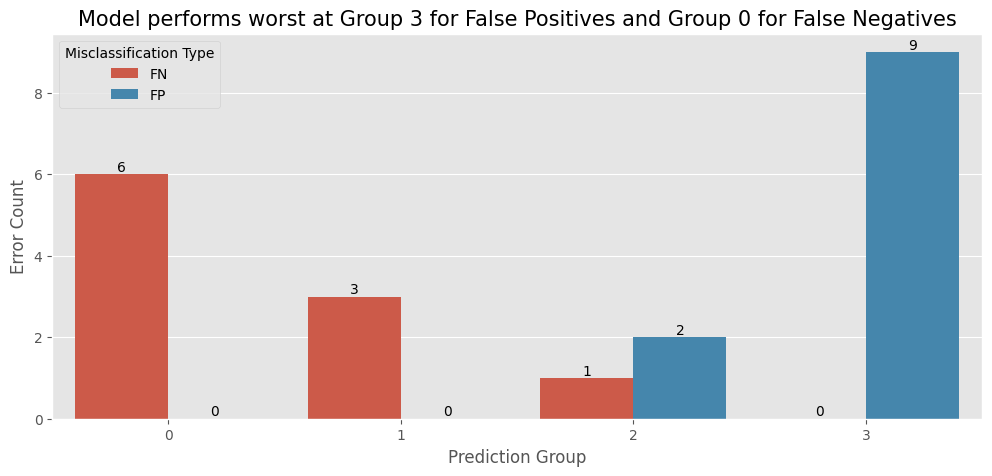

In [398]:
# calculate misclassifications
fn_fp_by_group = (mispredictions.groupby('Group')[['FN', 'FP']].sum().reset_index())

# plot the data
plt.figure(figsize=(12, 5))
ax = sns.barplot(x='Group', y='value', hue='variable', 
                 data=pd.melt(fn_fp_by_group, ['Group']))

# add labels on top
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                xy=(p.get_x() + p.get_width() / 2., height),
                xytext=(0, 5),  
                textcoords='offset points',
                ha='center', va='center')

plt.title('Model performs worst at Group 3 for False Positives and Group 0 for False Negatives', 
          fontsize=15)
plt.xlabel('Prediction Group', fontsize=12)
plt.ylabel('Error Count', fontsize=12)
plt.legend(title='Misclassification Type')
plt.show()

**Note**
- The output above shows similar output with the confusion matrix shown earlier but here I also display the misprediction rate along with specific entries in which the model makes mistakes in its predictions. In brief, the rate of mispredictions is small ($\approx$ 6% of the testing set). In addition to this, based on the bar chart, group 0 and group 3 have the highest number of misclassifications. The difference is while the misclassifications in group 0 are false neegatives (actual male but predicted as female), group 3 consists of 9 false positives (actual femalee but predicted as male). To this point, I need to check the descriptive statistics of the predicted probabilities in both groups.
- In the dataframe below, let us consider column `ProbM` (probability of instance being male) errors in Group 0 happen when the predicted probability range is closer to 0 (Female) than to 1 (Male), resulting the model's decision to consider the name female. For this reason, the errors are false negatives.
- In group 3, false positives are mostly situated in. The misclassifications occur when the predicted probabilities are closer to 1 (male) than to 0 (female). As a result, the model incorrectly consider some instances to be male when they should be female.

In [399]:
# get mean of probability
(mispredictions[(mispredictions['Group'] == 0) | (mispredictions['Group'] == 3)]
 .groupby('Group', as_index=False)
 .agg(func={'ProbM':'describe', 'ProbF':'describe'})
 .round(3))

Group ProbM                                              ProbF         \
        count   mean    std   min    25%   50%   75%   max count   mean   
0     0   6.0  0.065  0.063  0.02  0.035  0.05  0.05  0.19   6.0  0.935   
1     3   9.0  0.870  0.055  0.79  0.840  0.88  0.91  0.94   9.0  0.130   

                                         
     std   min   25%   50%    75%   max  
0  0.063  0.81  0.95  0.95  0.965  0.98  
1  0.055  0.06  0.09  0.12  0.160  0.21

##### **3.4.7.1 Why did the model make such misclassifications? What name components do the instances have?**

In [400]:
# Create a dictionary of feature to importance mapping
feature_importance_dict = dict(zip(feature_importance['Feature'], 
                                   feature_importance['Importance']))

# Initialize a list to store the results
results = []

# Check if any feature from 'feature_importance' is in 'Name' column of 'fp_df'
for idx, row in mispredictions.iterrows():
    name = row['Name']
    # Check for any feature in the current name
    matched_features = [(feature, round(feature_importance_dict[feature], 2)) 
                        for feature in feature_importance['Feature'] if feature in name]
    if matched_features:
        feature_pairs = ', '.join([f'({feature}, {importance:.2f})' 
                                   for feature, importance in matched_features])
        results.append({'Name': name, 'Feature': feature_pairs})

# Create a DataFrame from the results
output = pd.DataFrame(results)

combined_df = pd.merge(left=mispredictions, right=output, on='Name')

In [401]:
# FN: predicted female but actually male
combined_df[combined_df['Group'] == 0]

,Name,Actual,Predicted,ProbM,ProbF,FN,FP,Group,Feature
3,sarminah,1,0,0.03,0.97,True,False,0,"(nah, -0.28), (rmi, -0.20), (ina, -0.20), (sar, -0.19), (min, 0.07), (arm, -0.01)"
5,noviana anggraeni,1,0,0.05,0.95,True,False,0,"(na , -0.65), (eni, -0.17), (ian, -0.14), (ana, -0.11), (gra, 0.10), (ggr, -0.10), (aen, -0.05), (via, -0.04), (ang, 0.01), (ngg, -0.01), ( an, -0.01), (nov, -0.00), (rae, 0.00), (ovi, 0.00)"
8,mulyana,1,0,0.19,0.81,True,False,0,"(yan, -0.21), (ana, -0.11), (mul, 0.10), (lya, -0.03), (uly, 0.00)"
14,warsini,1,0,0.05,0.95,True,False,0,"(ini, -0.48), (war, -0.21), (sin, 0.20), (ars, -0.14), (rsi, -0.14)"
15,fathiya hasyifah sibarani,1,0,0.02,0.98,True,False,0,"(ah , -0.98), (ani, -0.49), (ara, -0.38), (iya, -0.28), ( si, -0.22), (ya , -0.17), (ifa, -0.13), ( ha, 0.12), (iba, -0.10), (ath, 0.10), (sib, 0.10), (syi, -0.10), (thi, 0.10), (yif, -0.10), (asy, -0.10), (fat, 0.09), (bar, 0.08), (has, 0.04), (ran, -0.02), (fah, -0.00)"
19,ida budiani,1,0,0.05,0.95,True,False,0,"(ani, -0.49), (udi, 0.28), (dia, -0.22), (ida, -0.14), (ian, -0.14), (da , -0.11), ( bu, 0.09), (bud, 0.00)"


**Note**
- To explain why the model made false negatives, I will exemplify first-three instances, namely *sarminah*, *noviana anggraeni*, *mulyana*.
- First, *sarminah* is male (`1`) but predicted as female (`0`). This error stems from the components of the name which have negative values contributing to the prediction of female. The n-gram *nah* appearing at the end of the name, for example, is all associated with female so the model predicted *sarminah* as female.
- Next, let us see why *noviana anggraeni* is mistakenly predicted as female by the model. Based on the n-grams, *na* appearing at the end of the name drags the prediction to female. As shown below, while there are some first or middle names ending with *na_*, the majority of instances are female. The higher frequency of names associated with female than male could be the main reason for such error.
- Third, *mulyana* was also incorrectly predicted as female. The model's decision is based on the n-gram *yan* wihch has negative coefficient, and hence, dragging the prediction to female.

In [402]:
# locate all names ending with "nah" in training set
nah = df_seen[(df_seen['name'].str.contains(r'.*nah\b', regex=True))].sort_values(by='gender')
nah_m = nah[nah['gender'] == 'm']
nah_f = nah[nah['gender'] == 'f']
if len(nah_m) > 0:
    print(f"Number of male names containing 'na_': {len(nah_m)}, e.g., {nah_m['name'].sample(3, random_state=42).tolist()}")
else:
    print(f"Number of male names containing 'na_': {len(nah_m)}")
if len(nah_f) > 0:
    print(f"Number of female names containing 'na_': {len(nah_f)}, e.g., {nah_f['name'].sample(3, random_state=42).tolist()}")
else:
    print(f"Number of female names containing 'na_': {len(nah_f)}")

Number of male names containing 'na_': 0
Number of female names containing 'na_': 22, e.g., ['tasminah', 'iswatun chasanah', 'asmunah']


In [403]:
# locate all first or middle names ending with "na_" in training set
na_ = df_seen[(df_seen['name'].str.contains(r'^\w*na\s', regex=True))].sort_values(by='gender')
na_m = na_[na_['gender'] == 'm']
na_f = na_[na_['gender'] == 'f']
print(f"Number of male names containing 'na_': {len(na_m)}, e.g., {na_m['name'].sample(3, random_state=42).tolist()}")
print(f"Number of female names containing 'na_': {len(na_f)}, e.g., {na_f['name'].sample(3, random_state=42).tolist()}")

Number of male names containing 'na_': 6, e.g., ['erna lestari', 'hana aida sahila', 'maulana koto']
Number of female names containing 'na_': 15, e.g., ['ratna wati', 'devina tria ananda', 'vina nailatul izzah']


In [404]:
# locate all first or middle names ending with "yan" in training set
yan = df_seen[(df_seen['name'].str.contains(r'yan', regex=True))].sort_values(by='gender')
yan_m = yan[yan['gender'] == 'm']
yan_f = yan[yan['gender'] == 'f']
print(f"Number of male names containing 'yan': {len(yan_m)}, e.g., {yan_m['name'].sample(3, random_state=42).tolist()}")
print(f"Number of female names containing 'yan': {len(yan_m)}, e.g., {yan_f['name'].sample(3, random_state=42).tolist()}")

Number of male names containing 'yan': 31, e.g., ['mujiriyanto', 'dede adiyanto', 'lilik supriyanto']
Number of female names containing 'yan': 31, e.g., ['rindi septia yanmilani', 'eti nurcahyani', 'mila yuli yanti']


In [405]:
# FP: predicted male but actually female
combined_df[combined_df['Group'] == 3]

,Name,Actual,Predicted,ProbM,ProbF,FN,FP,Group,Feature
0,ridha ulva,0,1,0.93,0.07,False,True,3,"(lva, -0.10), (ulv, 0.10), (idh, 0.10), ( ul, 0.08), (rid, 0.07), (dha, -0.06), (ha , -0.06)"
1,temen,0,1,0.84,0.16,False,True,3,"(tem, -0.10)"
2,air murya,0,1,0.90,0.10,False,True,3,"(ir , 0.24), (air, 0.12), (ury, 0.06), (mur, 0.03), ( mu, -0.03), (rya, -0.00)"
4,evi alisma,0,1,0.94,0.06,False,True,3,"(sma, 0.18), ( al, 0.18), (ali, 0.17), (ism, 0.08), (vi , -0.07), (lis, -0.05), (evi, -0.04)"
6,alfazola,0,1,0.79,0.21,False,True,3,"(alf, 0.13), (ola, 0.10), (lfa, 0.10), (faz, 0.00)"
12,nova kharisma,0,1,0.91,0.09,False,True,3,"(ari, -0.26), (sma, 0.18), (kha, 0.17), (har, 0.11), (ova, 0.10), (ism, 0.08), (ris, -0.05), (va , -0.02), ( kh, -0.02), (nov, -0.00)"
17,soetry dinata arya maulana,0,1,0.88,0.12,False,True,3,"( ar, 0.35), (aul, 0.26), (mau, 0.21), (ina, -0.20), (ya , -0.17), (ta , -0.16), (lan, 0.15), (ata, 0.14), ( di, 0.14), (ana, -0.11), (ry , -0.08), (din, 0.06), ( ma, 0.05), (ary, 0.04), (ula, -0.04), (nat, -0.01), (rya, -0.00), (try, 0.00), (etr, 0.00)"
18,wahyu tri pamungkas,0,1,0.80,0.20,False,True,3,"(tri, -0.33), ( tr, 0.28), (yu , -0.18), (ri , -0.16), ( pa, 0.12), (hyu, -0.06), (wah, -0.06), (ung, 0.05), (ngk, 0.03), (ahy, 0.02), (kas, 0.01), (gka, -0.01), (mun, 0.01)"
20,dian nur assyfa,0,1,0.84,0.16,False,True,3,"(an , 0.59), (nur, -0.27), (dia, -0.22), ( nu, -0.21), (ian, -0.14), (ur , 0.10), (ass, 0.04), ( as, 0.03), (ssy, 0.00)"


**Note**
- Similar to the false negative cases, I will also explain the first-three false positives, i.e., *ridha ulva*, *temen*, and *air murya*, who were predicted as male (`1`) when actually female (`0`).
- **ridha ulva**: This individual's name consists of *lva* with several positive coeffiients. This psoitive coefficient is the main reason why the name is predicted as male.
- **temen** consists of *tem* with negative coefficient. In training data as shown by the code below, there is only one instance containing *tem* (female).
- **air murya** comprises of mostly positive 3-character n-grams with positive coefficients, and the highest coefficient is coming from *ir_* dragging the prediction to male.

In [406]:
# locate all names ending with "ulv" in training set
ulv = df_seen[(df_seen['name'].str.contains(r'ulv', regex=True))].sort_values(by='gender')
ulv_m = ulv[ulv['gender'] == 'm']
ulv_f = ulv[ulv['gender'] == 'f']
if len(ulv_m) > 0:
    print(f"Number of male names containing 'ulv': {len(ulv_m)}, e.g., {ulv_m['name'].sample(2, random_state=42).tolist()}")
else:
    print(f"Number of male names containing 'ulv': {len(ulv_m)}")
if len(ulv_f) > 0:
    print(f"Number of female names containing 'ulv': {len(ulv_f)}, e.g., {ulv_f['name'].sample(3, random_state=42).tolist()}")
else:
    print(f"Number of female names containing 'ulv': {len(ulv_f)}")

Number of male names containing 'ulv': 2, e.g., ['ulviana agustina', 'zulvan arfa syazwan']
Number of female names containing 'ulv': 0


In [407]:
# locate all names ending with "tem" in training set
tem = df_seen[(df_seen['name'].str.contains(r'tem', regex=True))].sort_values(by='gender')
tem_m = tem[tem['gender'] == 'm']
tem_f = tem[tem['gender'] == 'f']
if len(tem_m) > 0:
    print(f"Number of male names containing 'tem': {len(tem_m)}, e.g., {tem_m['name'].sample(3, random_state=42).tolist()}")
else:
    print(f"Number of male names containing 'tem': {len(tem_m)}")
if len(tem_f) > 0:
    print(f"Number of female names containing 'tem': {len(tem_f)}, e.g., {tem_f['name'].sample(1, random_state=42).tolist()}")
else:
    print(f"Number of female names containing 'tem': {len(tem_f)}")

Number of male names containing 'tem': 0
Number of female names containing 'tem': 1, e.g., ['yatemi']


In [408]:
# locate all names ending with "ir_" in training set
ir_ = df_seen[(df_seen['name'].str.contains(r'^\w+ir\s', regex=True))].sort_values(by='gender')
ir_m = ir_[ir_['gender'] == 'm']
ir_f = ir_[ir_['gender'] == 'f']
if len(ir_m) > 0:
    print(f"Number of male names containing 'ir_': {len(ir_m)}, e.g., {ir_m['name'].tolist()}")
else:
    print(f"Number of male names containing 'ir_': {len(ir_m)}")
if len(ir_f) > 0:
    print(f"Number of female names containing 'ir_': {len(ir_f)}, e.g., {ir_f['name'].sample(1, random_state=42).tolist()}")
else:
    print(f"Number of female names containing 'ir_': {len(ir_f)}")

Number of male names containing 'ir_': 2, e.g., ['amir mahdi', 'azwir irfan nanda']
Number of female names containing 'ir_': 0


### **3.5 Final Model Saving**

In [409]:
joblib.dump(calibrated_clf, '../model/final_model.pkl')
print('Model saved!')

Model saved!


## **4 Conclusions and Future Directions**
- Summary
- Future direction
- Limitations (model limitation, sample limitation)

Increasing sample size does not increase the effect size

In [410]:
from statsmodels.stats.power import TTestIndPower

# specify effect size, alpha, and power
effect_size = 0.1   # The effect size you aim for (Rank-Biserial Correlation Coefficient, exploratory)
alpha = 0.05        # Significance level
power = 0.95        # Desired power (1 - beta)

# perform power analysis
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, 
                                   alpha=alpha, power=power, 
                                   alternative='two-sided')
print(f"Ideal sample size for each group: {np.ceil(sample_size)}")

Ideal sample size for each group: 2600.0


<h1 span style='color:orange; text-align:center; font-weight:bold'>---END---</h1>